In [1]:
import numpy as np
import torch
import os
import math
import zarr
from matplotlib import pyplot as plt
import torch.nn as nn
from typing import Tuple, Sequence, Dict, Union, Optional
from diffusion_policy.dataset.curobo_dataset import CuroboDataset, unnormalize_data
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
np.set_printoptions(precision=3, suppress=True)
from IPython.display import clear_output, display

In [2]:
#@markdown ### **Network**
#@markdown
#@markdown Defines a 1D UNet architecture `ConditionalUnet1D`
#@markdown as the noies prediction network
#@markdown
#@markdown Components
#@markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
#@markdown - `Downsample1d` Strided convolution to reduce temporal resolution
#@markdown - `Upsample1d` Transposed convolution to increase temporal resolution
#@markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
#@markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
#@markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
#@markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


In [3]:
# load dataset
dataset_path = os.path.join(os.path.abspath('data'), 'logged_plans_03.zarr')
pred_horizon = 256
obs_horizon = 16
action_horizon = 128
#|o|o|                             observations: obs_horizon
#| |a|a|a|a|a|a|a|a|               actions executed: action_horizon
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: pred_horizon
#|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s| states: pred_horizon
dataset = CuroboDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
stats = dataset.stats # save training data statistics (min, max) for each dim
# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    num_workers=1,
    shuffle=True, # accelerate cpu-gpu transfer
    pin_memory=True, # don't kill worker process afte each epoch
    persistent_workers=True
)
# visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['obs'].shape: torch.Size([128, 16, 22])
batch['action'].shape torch.Size([128, 256, 4])


In [4]:
len(dataloader)

28271

In [5]:
#@markdown ### **Network Demo**

# observation and action dimensions corrsponding to
# the output of PushTEnv
obs_dim = 22
action_dim = 4

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim))
obs = torch.zeros((1, obs_horizon, obs_dim))
diffusion_iter = torch.zeros((1,))

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

number of parameters: 7.025972e+07


ready to train


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/28271 [00:00<?, ?it/s]

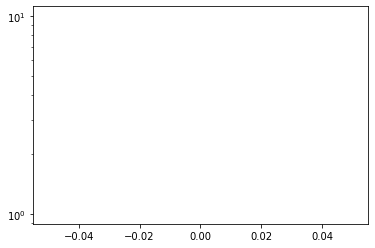

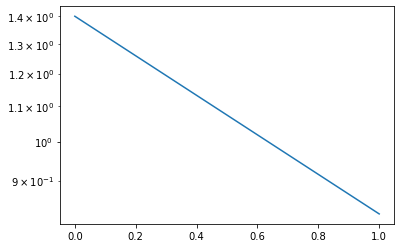

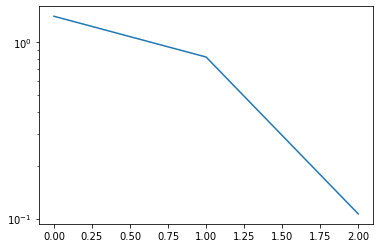

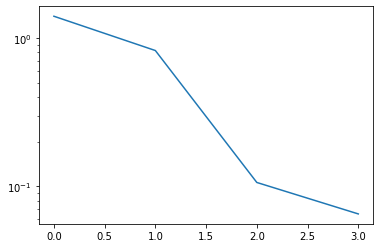

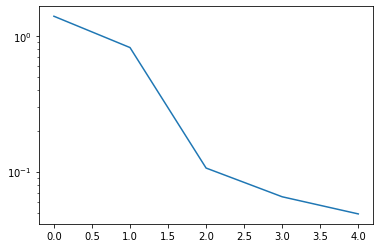

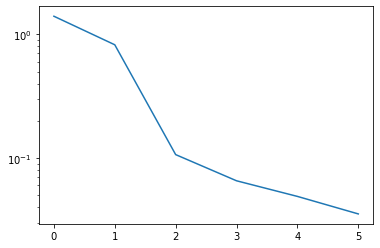

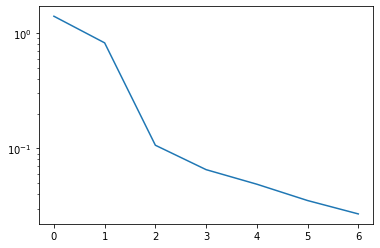

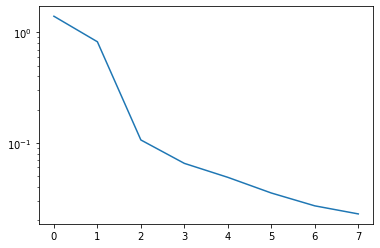

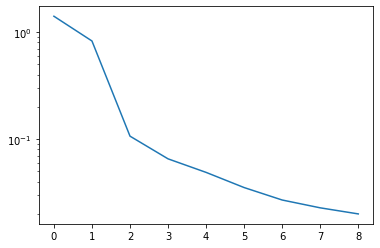

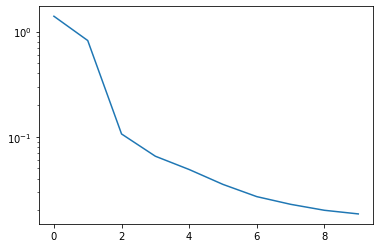

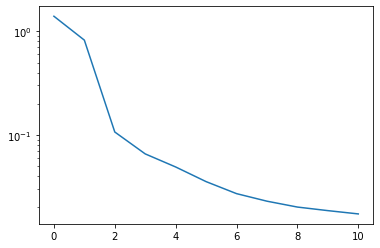

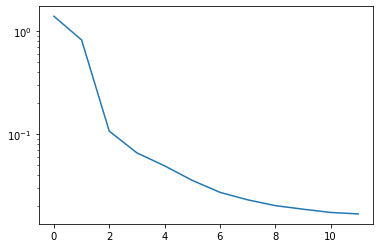

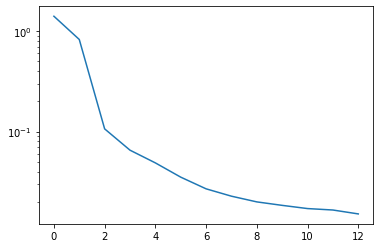

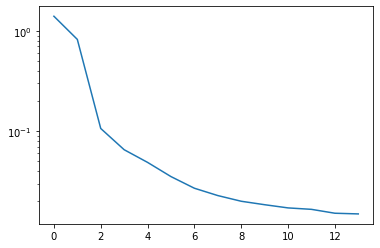

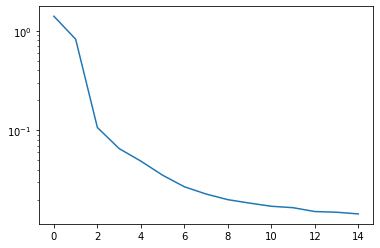

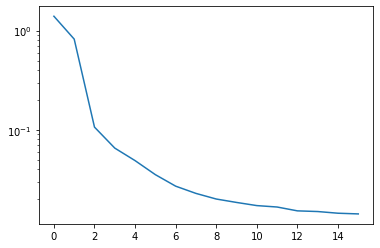

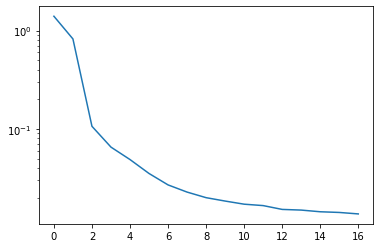

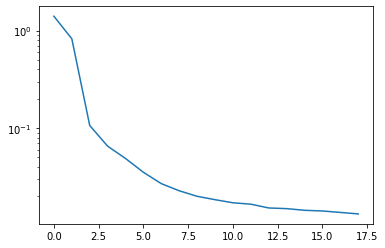

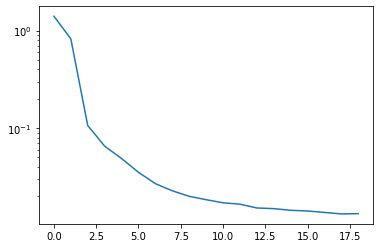

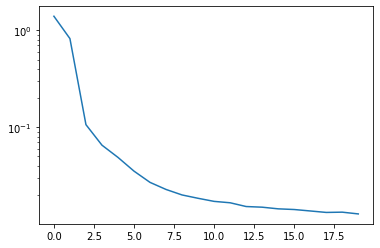

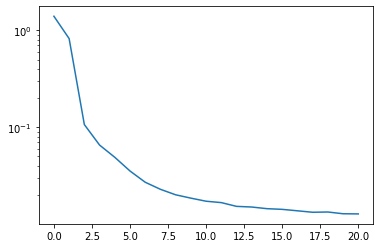

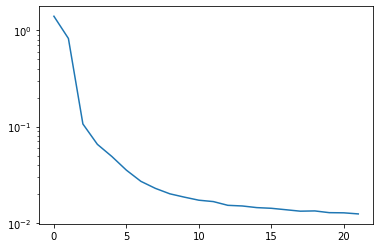

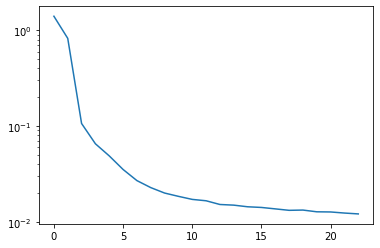

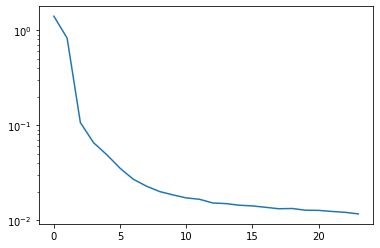

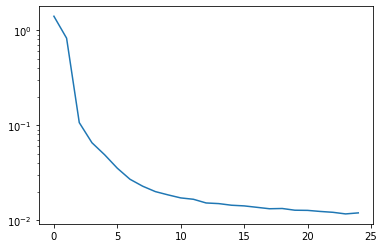

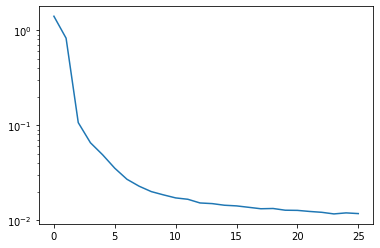

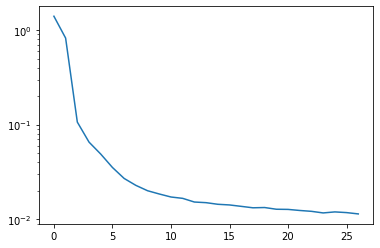

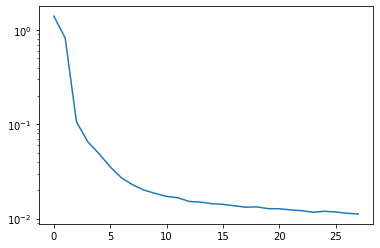

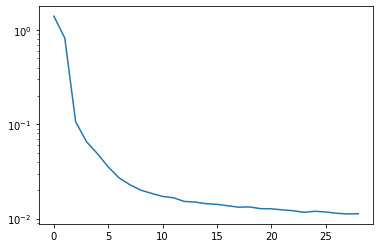

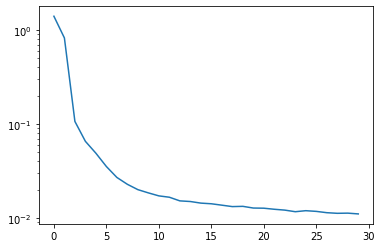

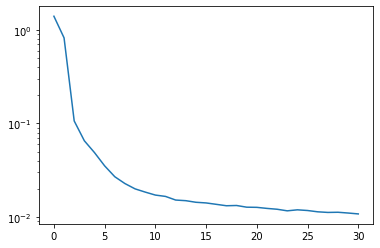

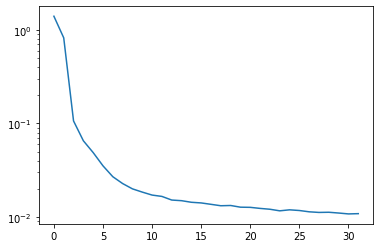

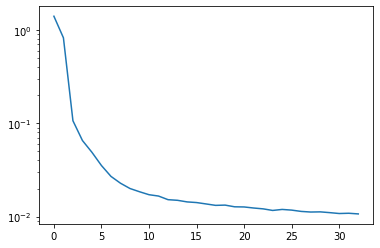

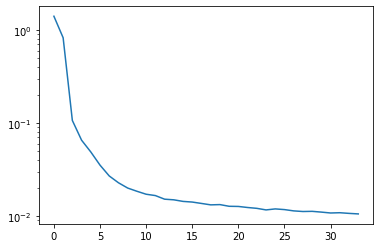

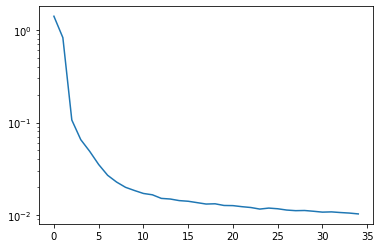

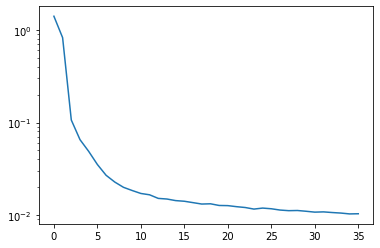

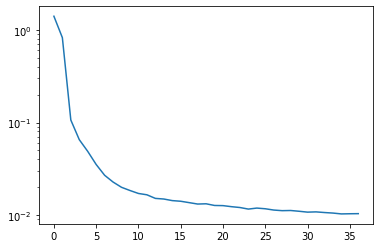

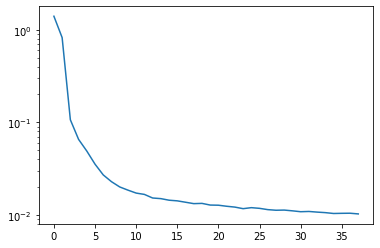

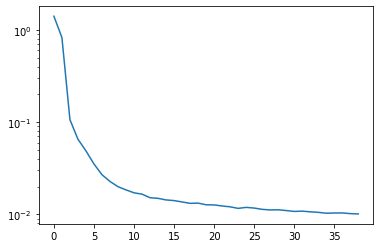

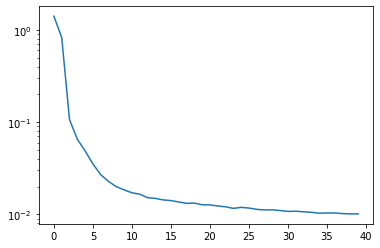

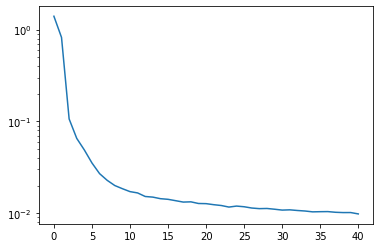

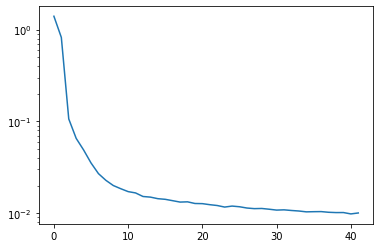

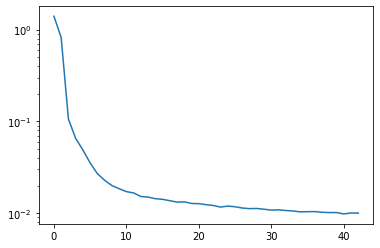

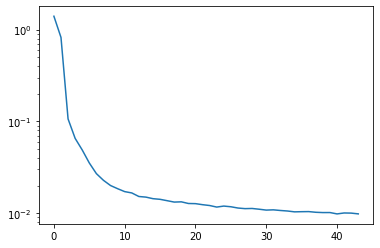

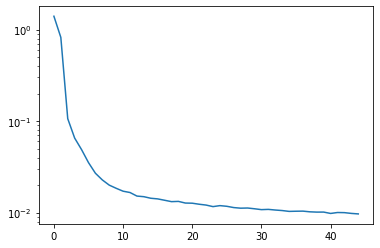

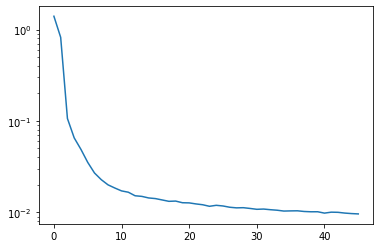

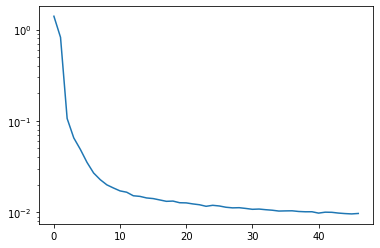

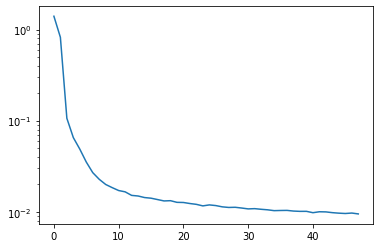

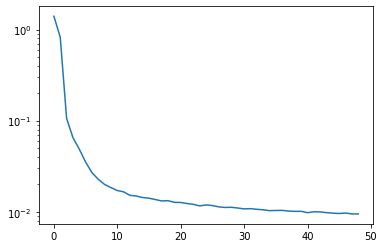

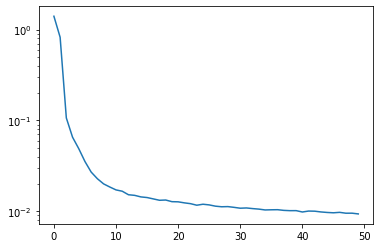

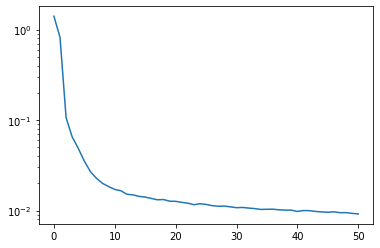

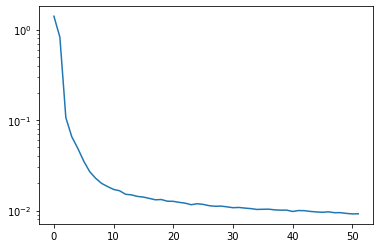

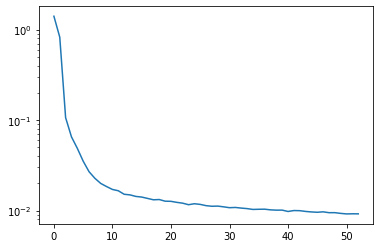

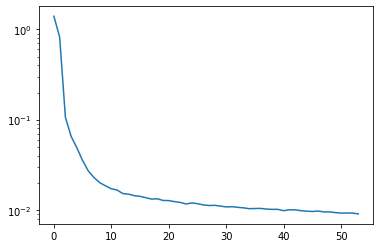

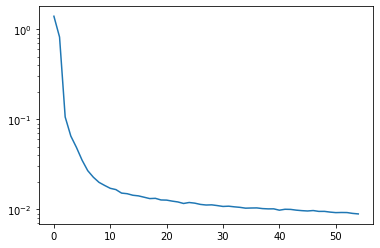

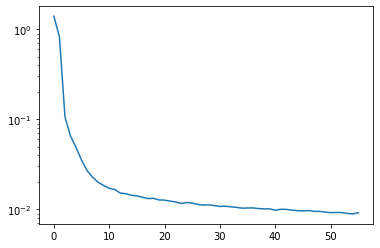

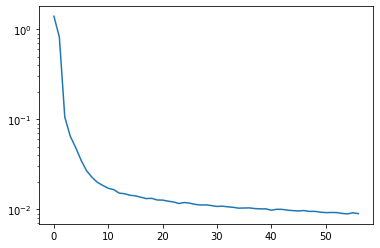

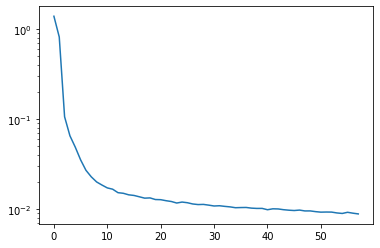

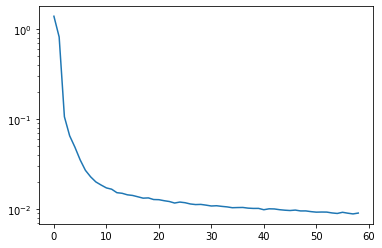

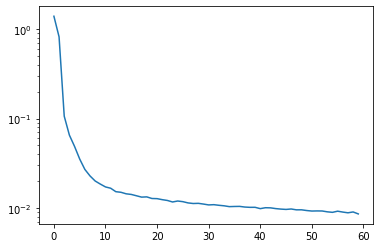

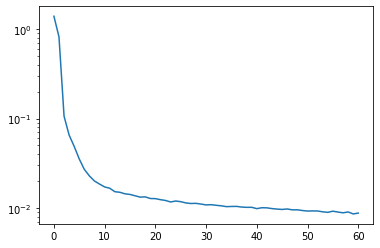

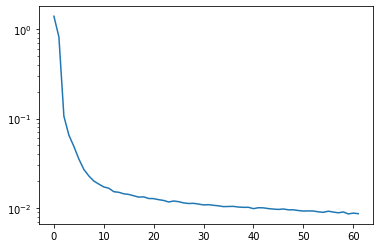

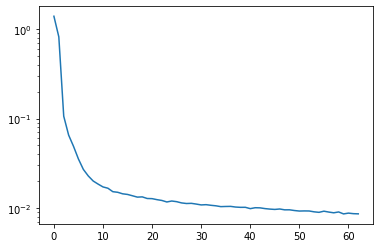

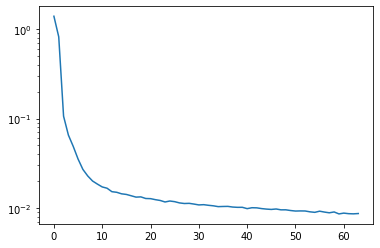

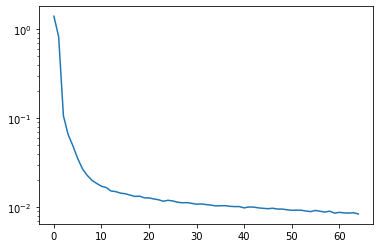

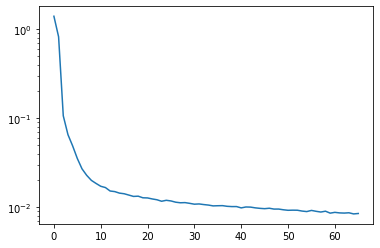

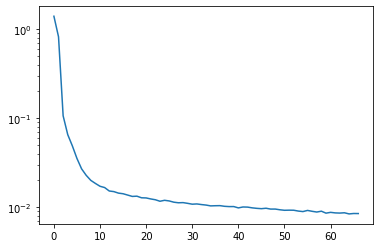

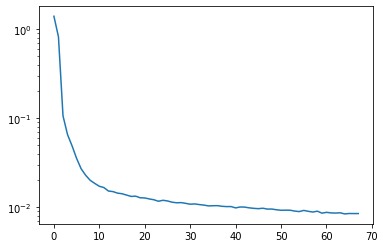

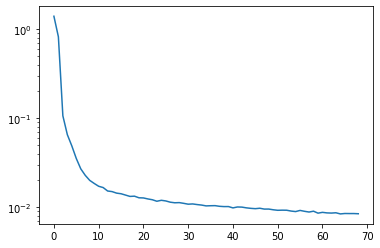

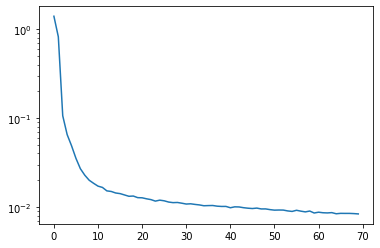

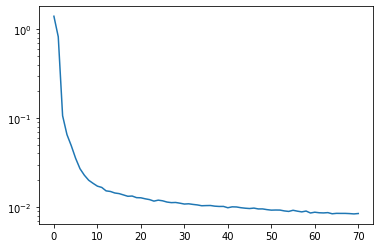

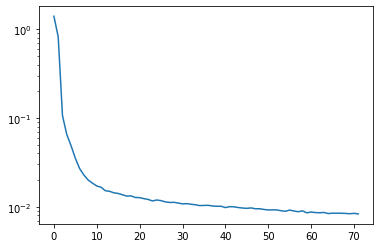

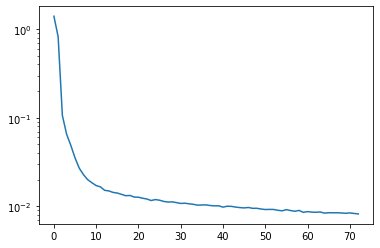

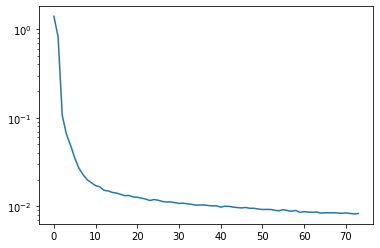

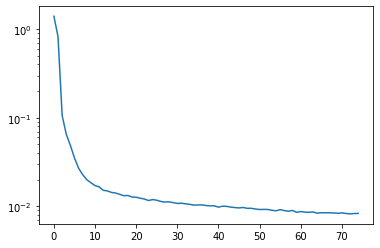

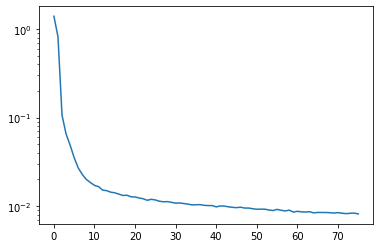

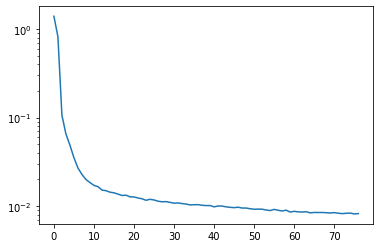

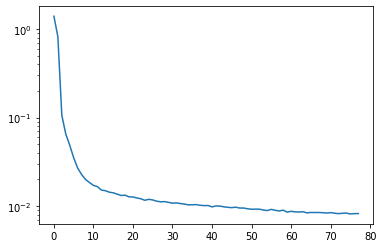

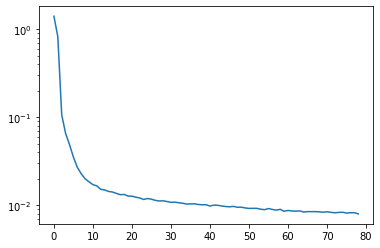

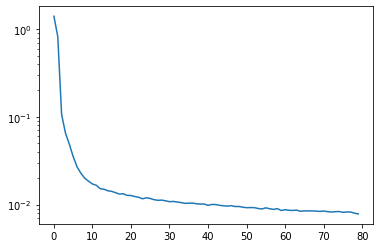

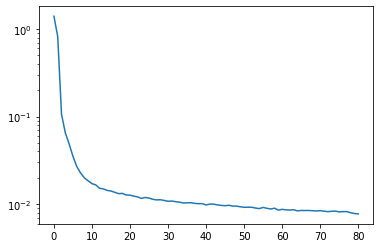

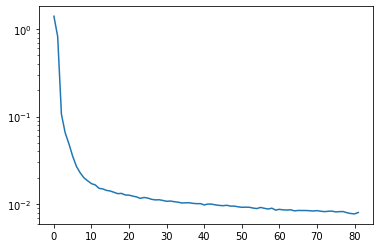

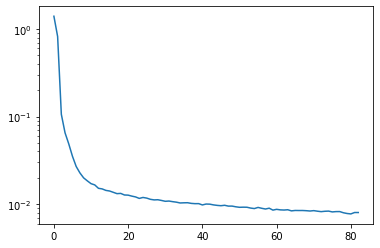

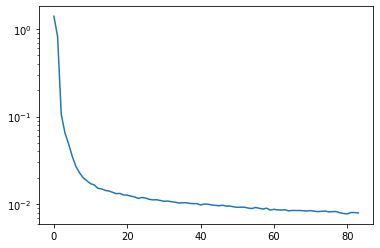

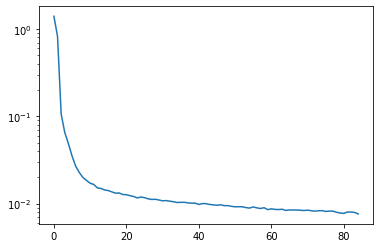

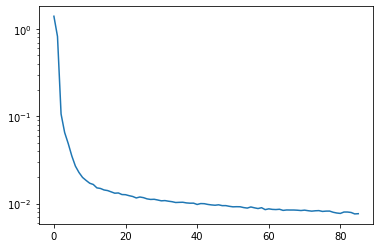

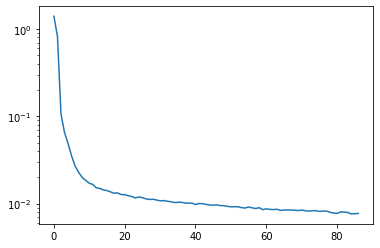

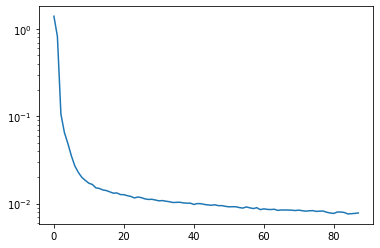

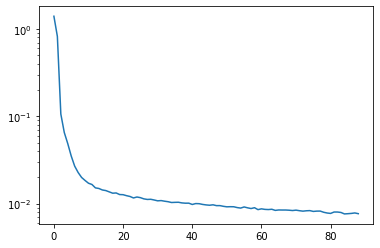

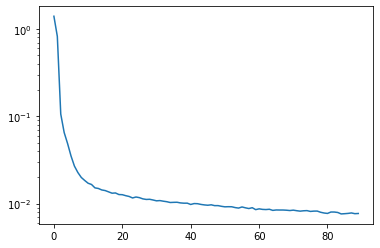

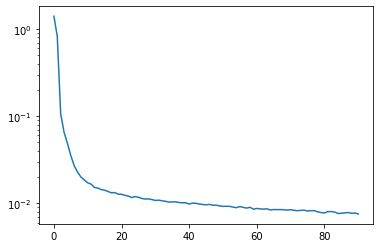

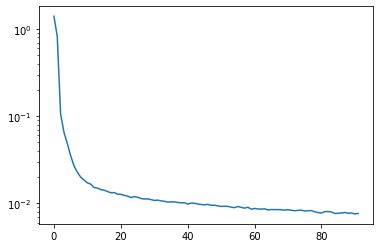

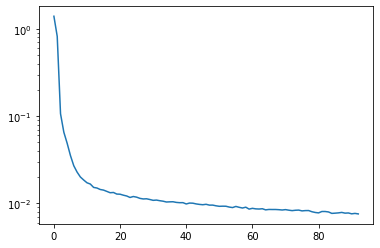

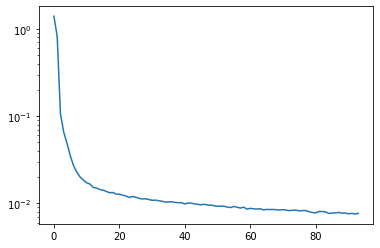

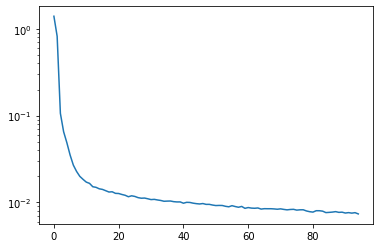

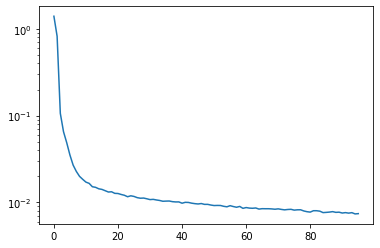

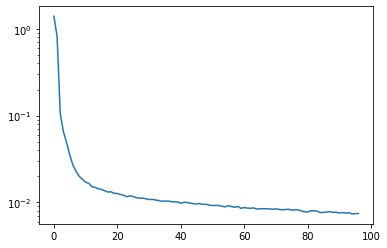

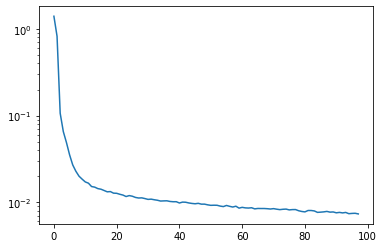

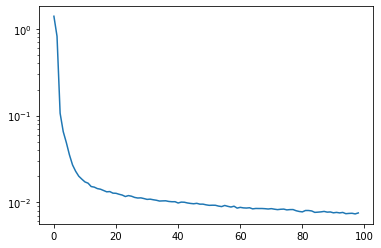

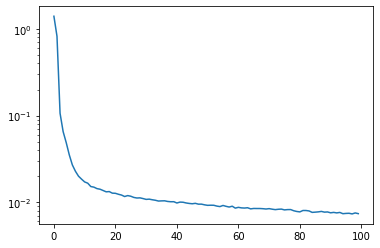

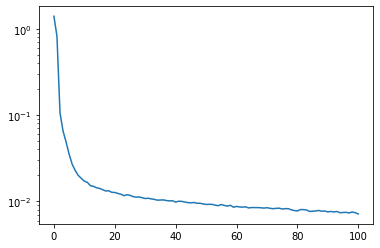

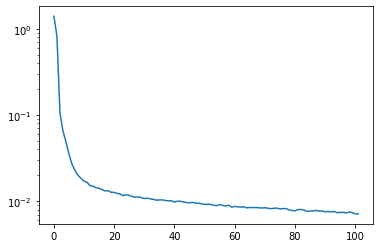

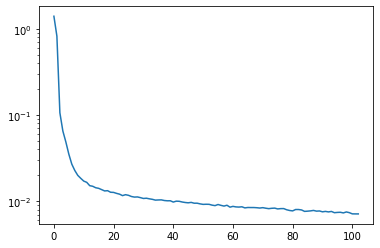

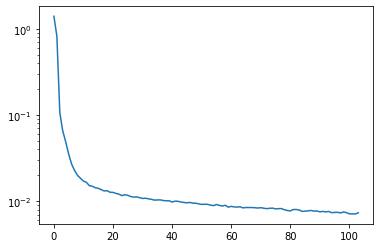

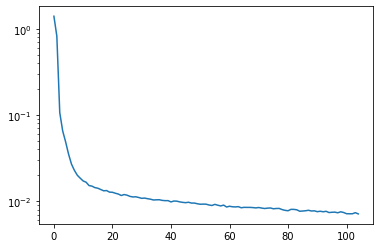

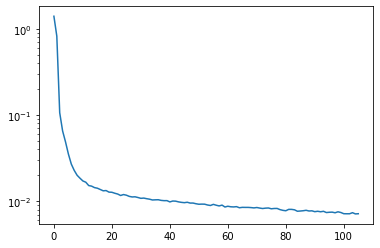

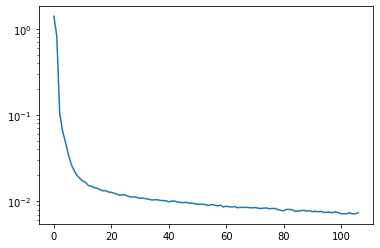

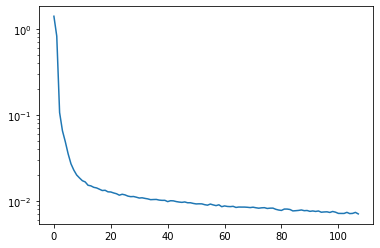

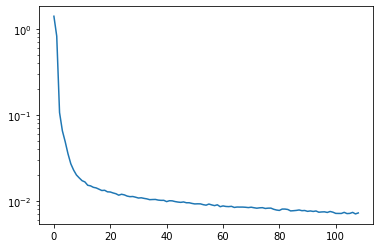

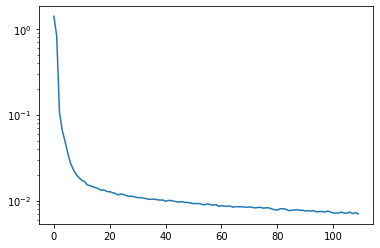

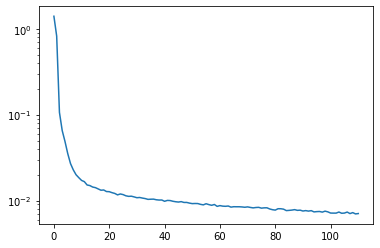

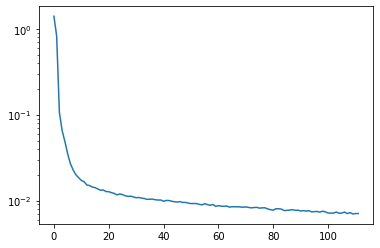

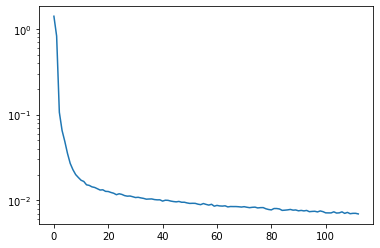

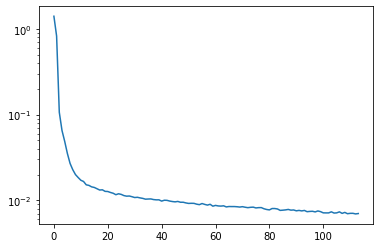

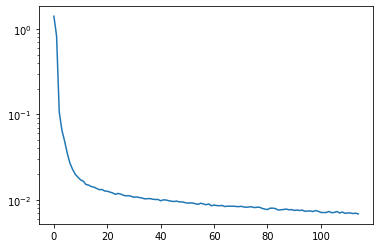

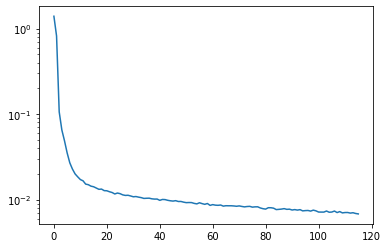

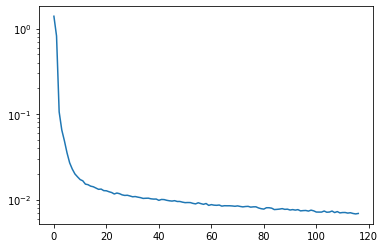

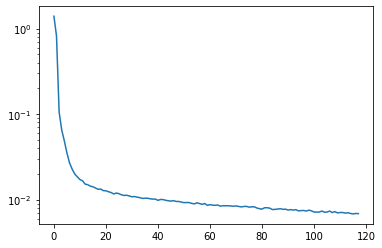

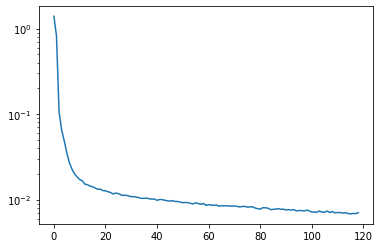

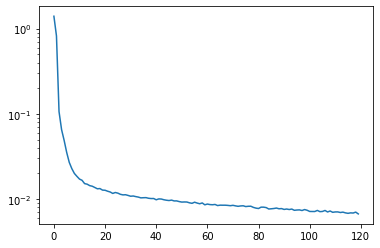

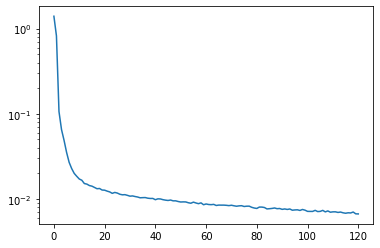

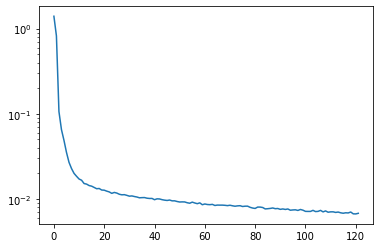

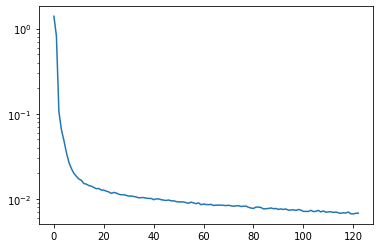

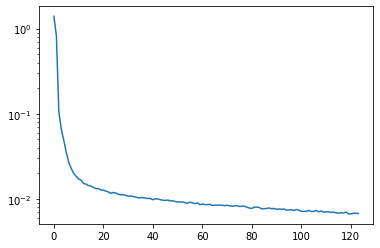

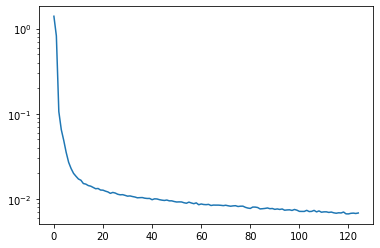

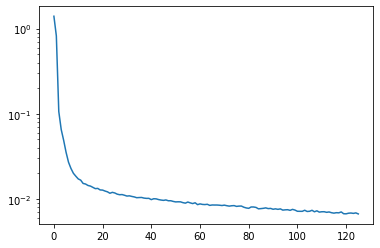

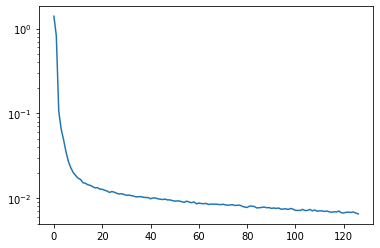

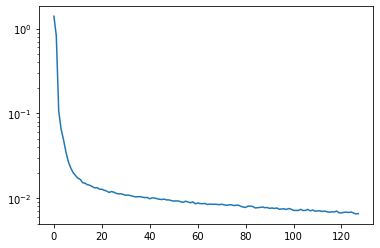

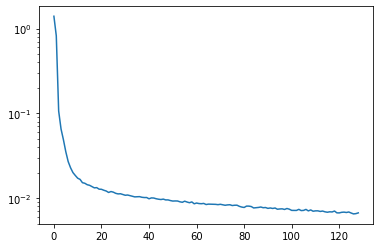

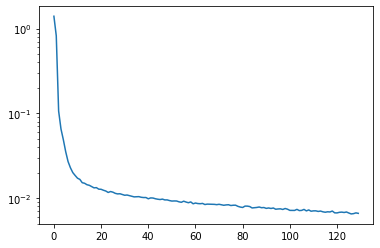

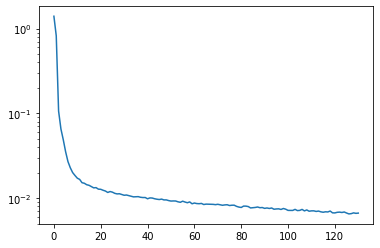

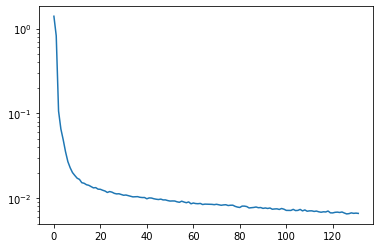

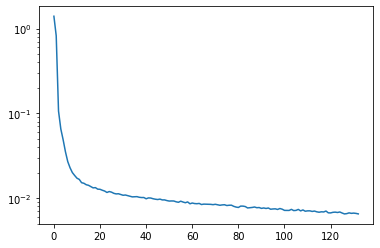

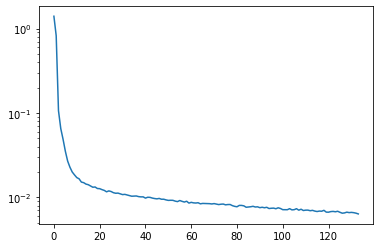

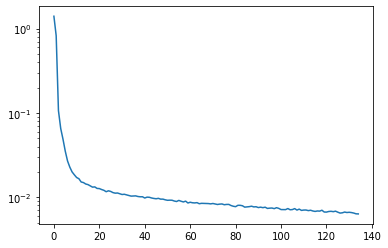

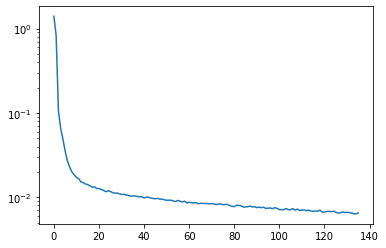

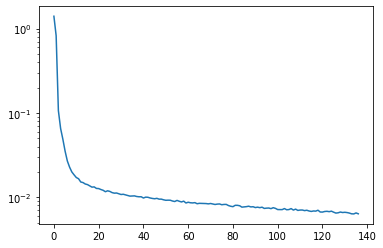

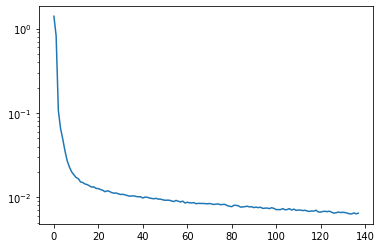

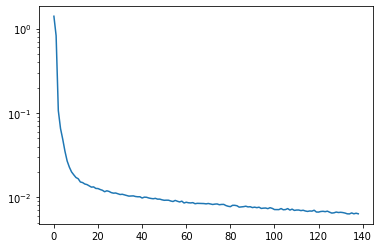

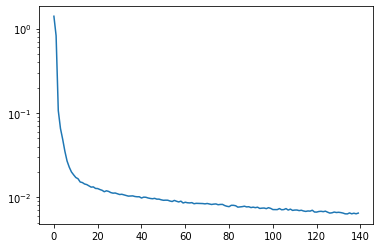

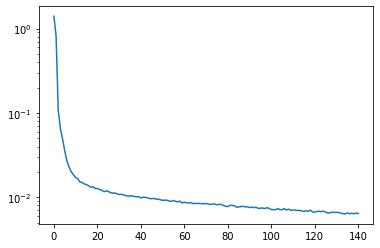

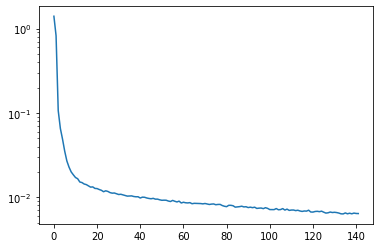

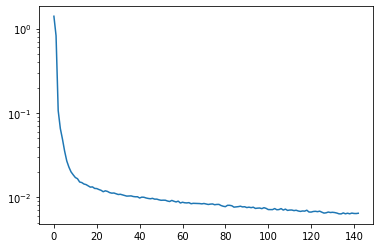

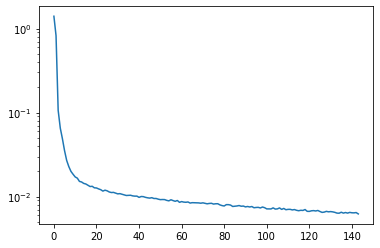

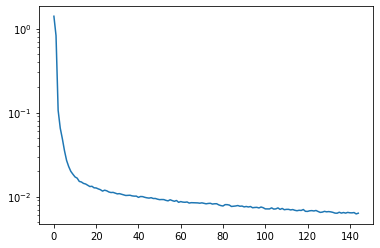

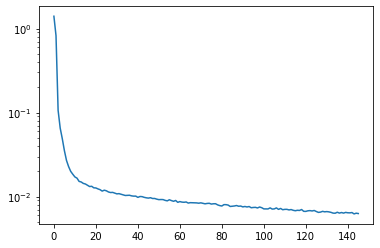

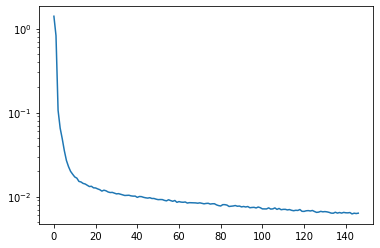

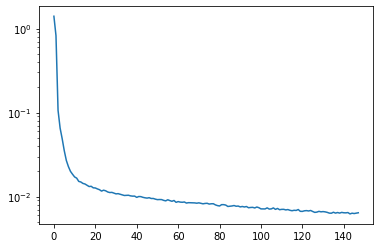

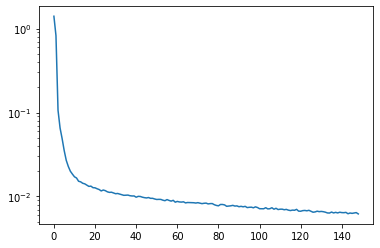

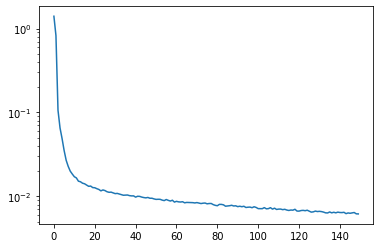

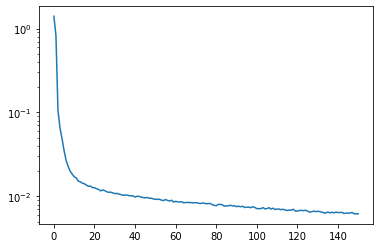

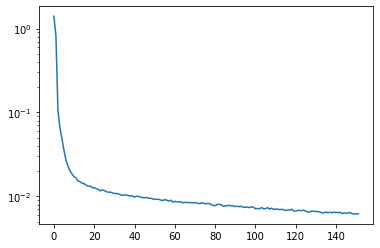

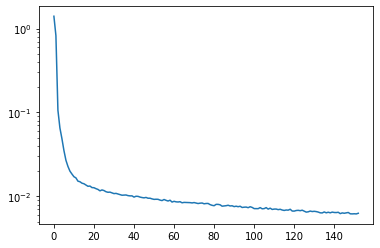

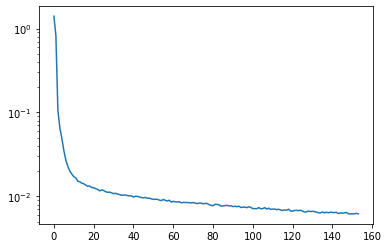

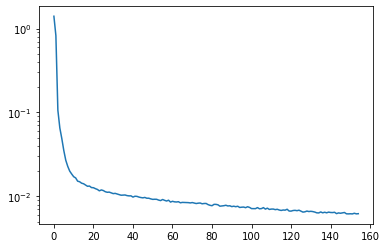

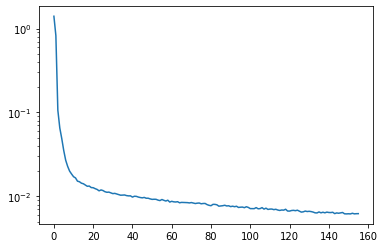

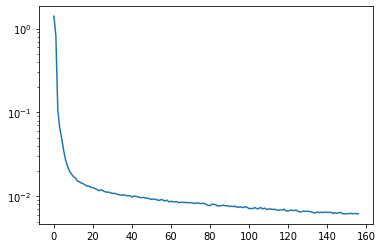

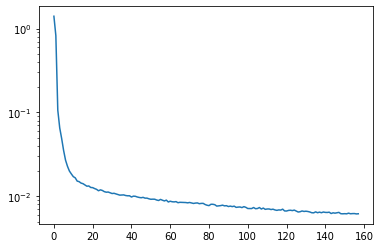

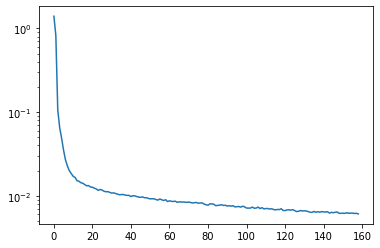

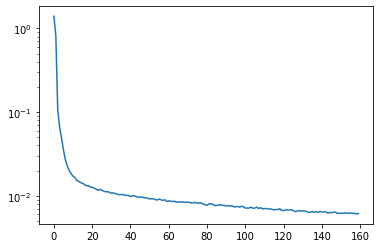

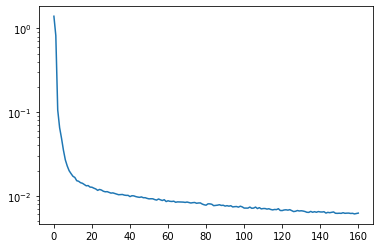

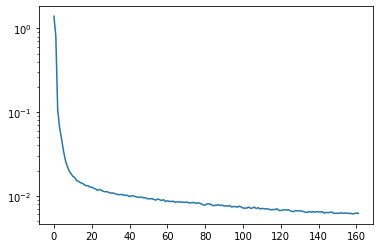

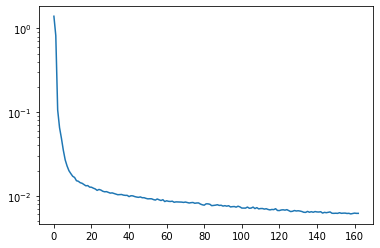

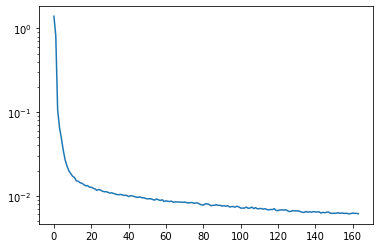

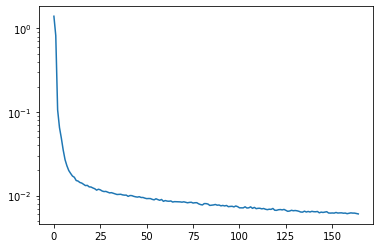

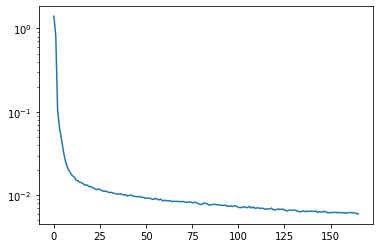

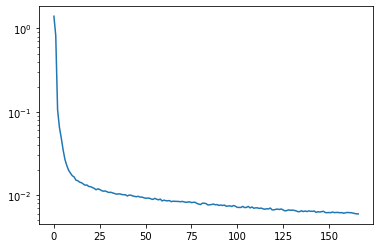

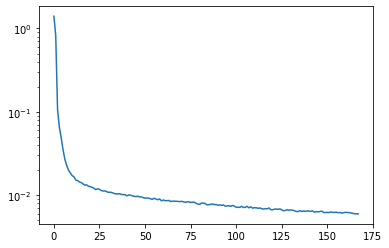

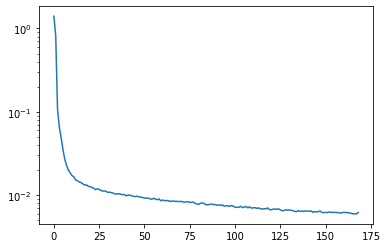

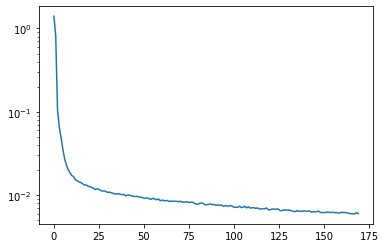

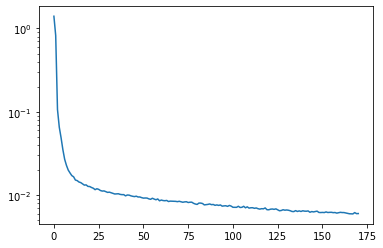

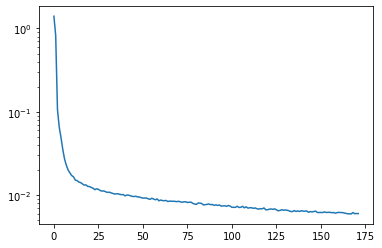

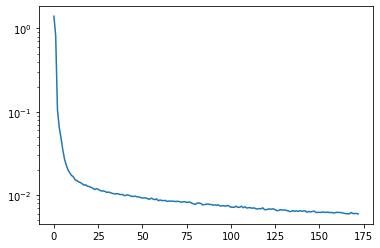

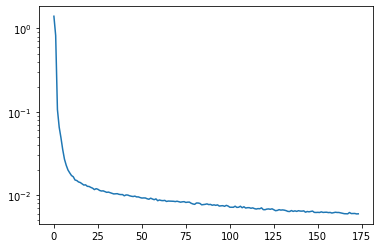

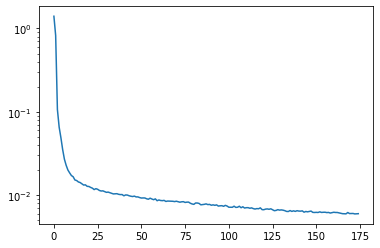

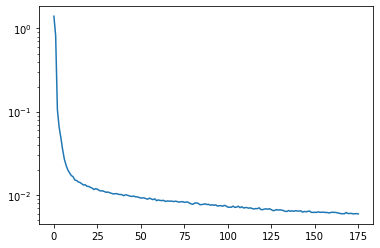

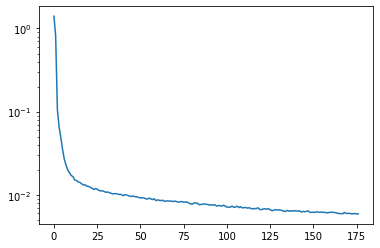

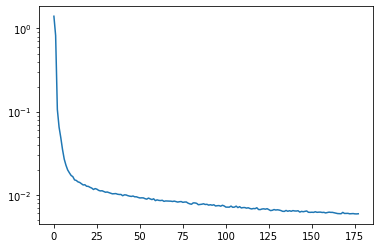

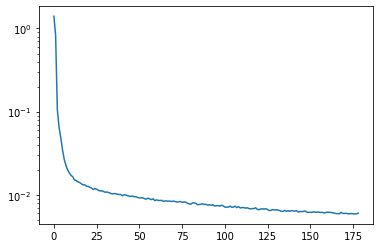

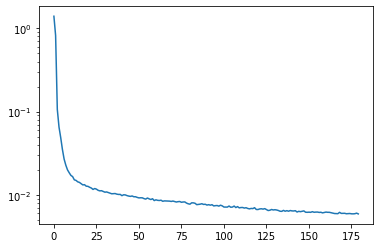

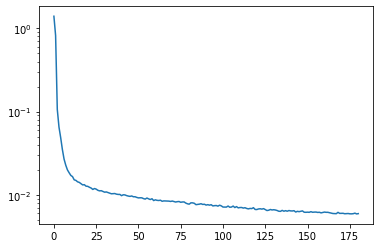

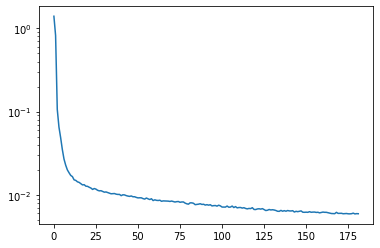

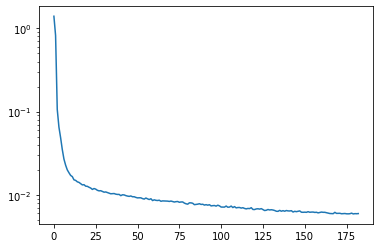

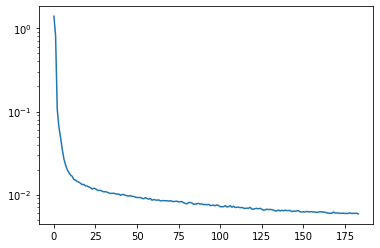

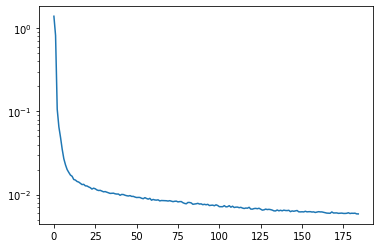

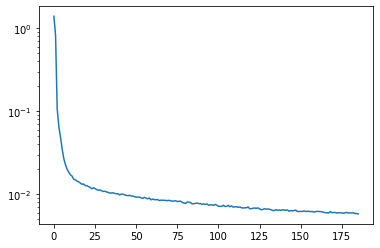

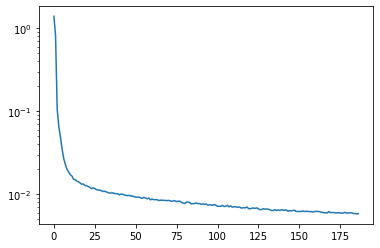

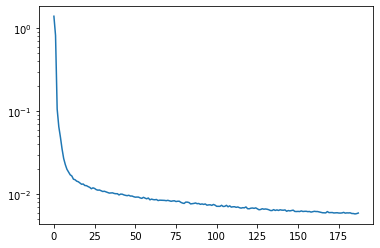

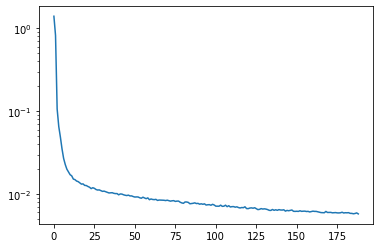

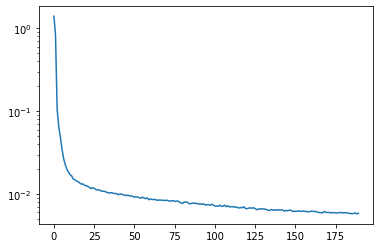

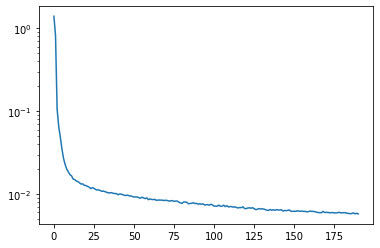

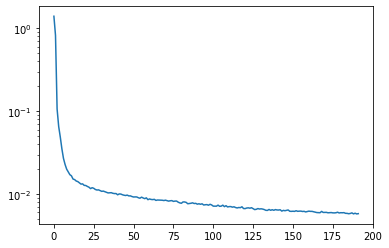

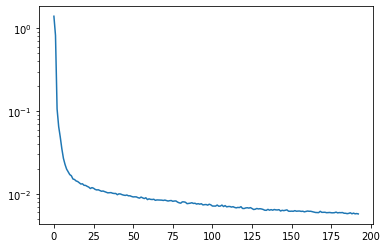

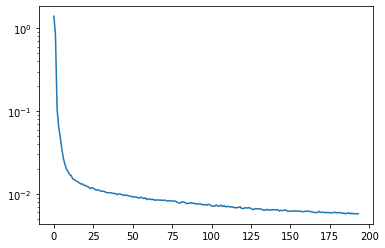

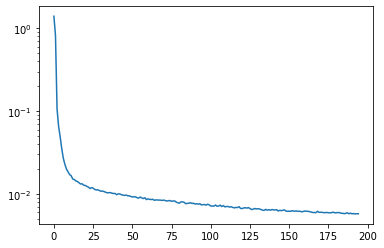

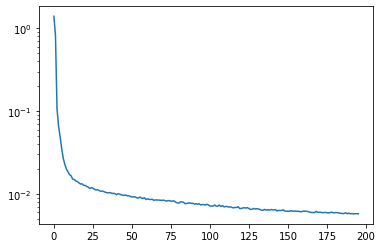

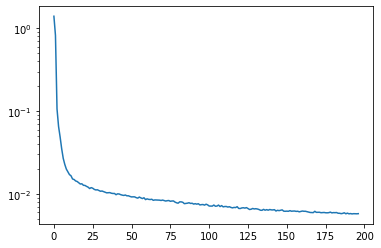

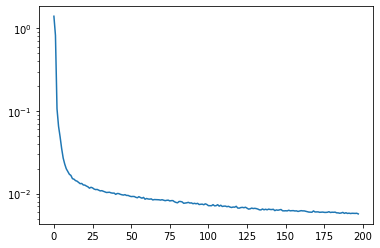

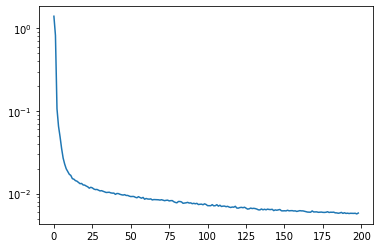

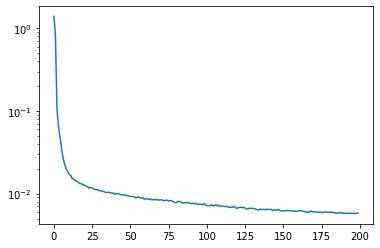

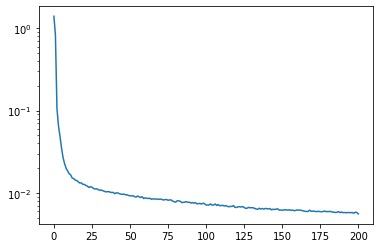

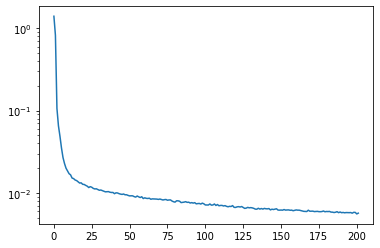

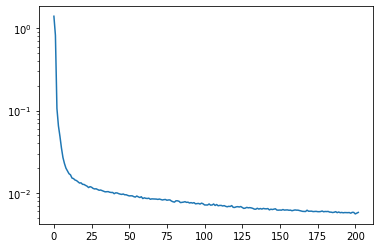

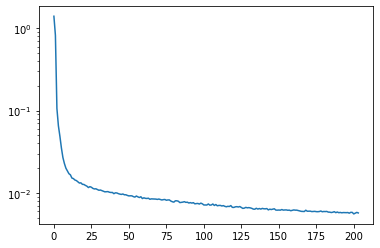

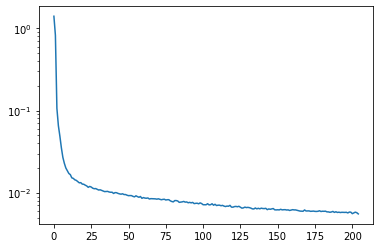

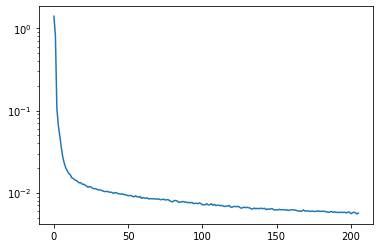

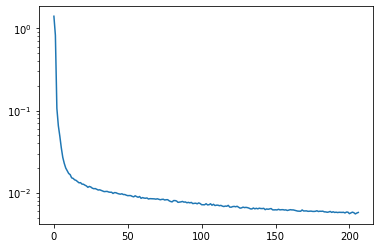

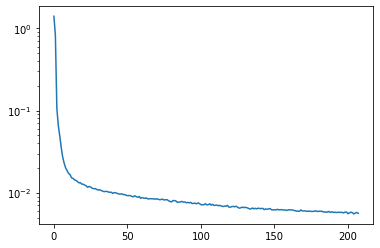

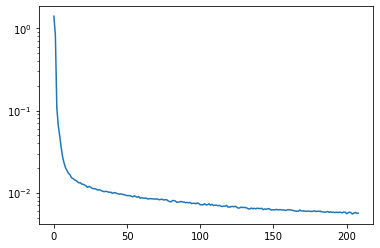

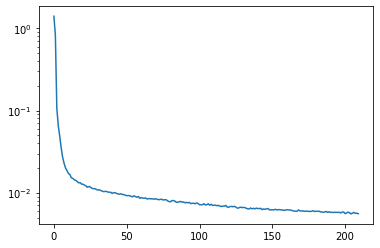

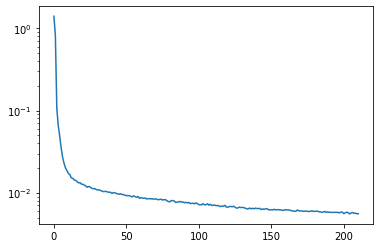

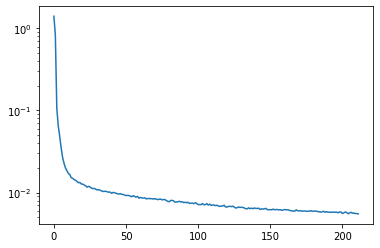

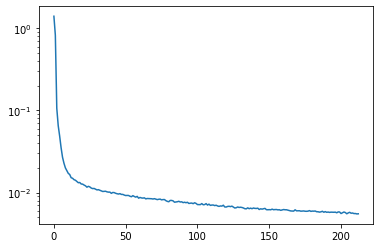

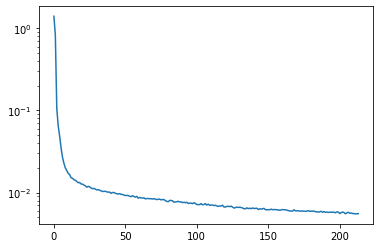

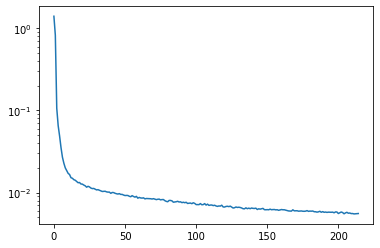

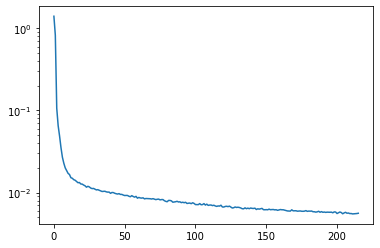

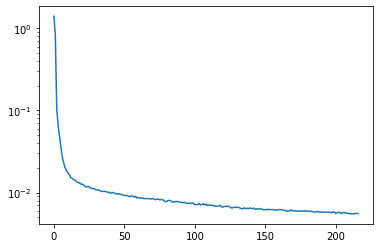

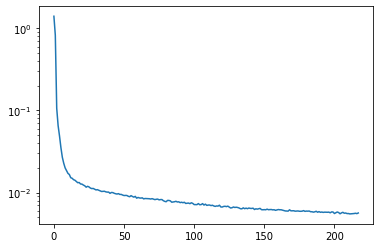

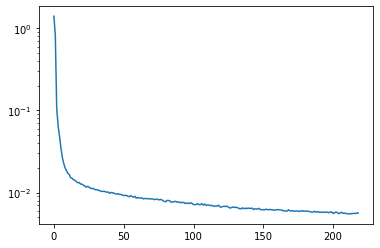

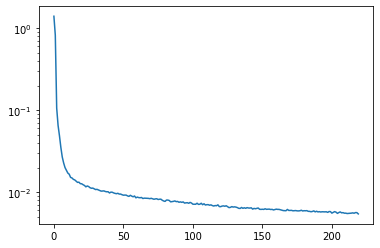

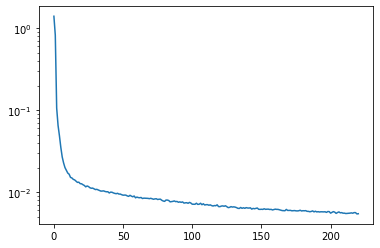

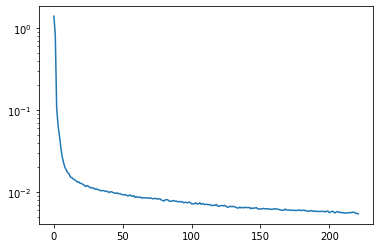

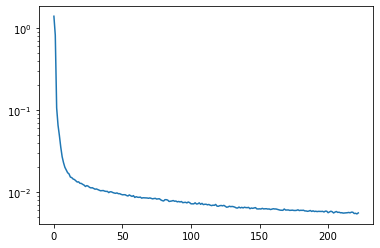

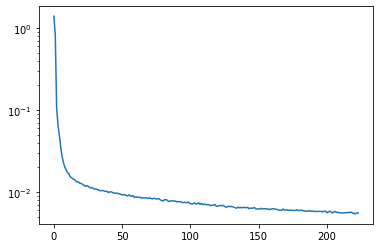

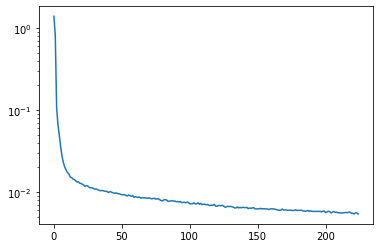

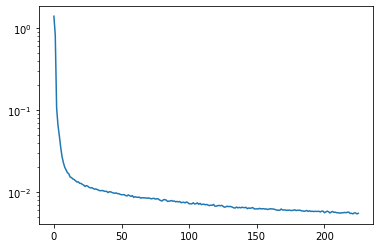

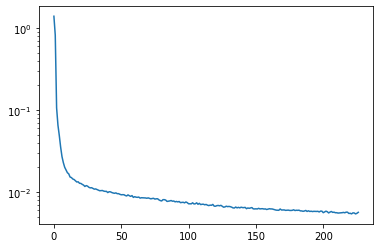

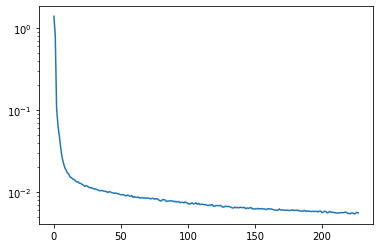

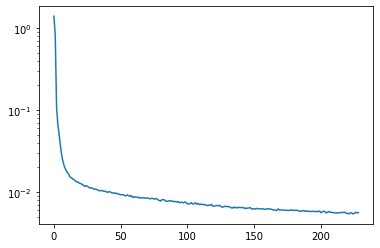

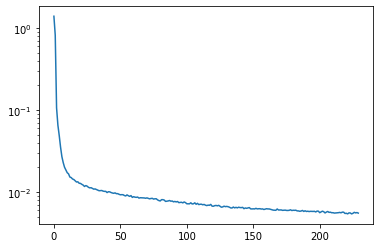

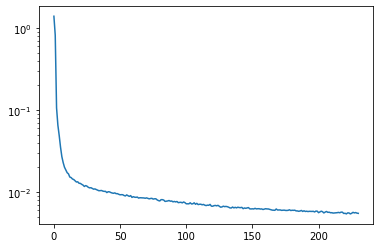

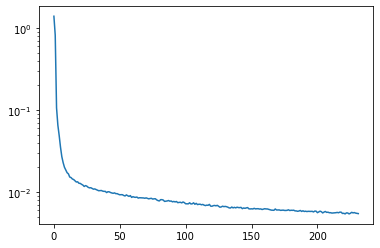

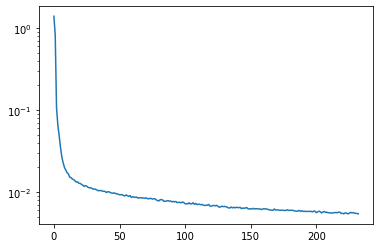

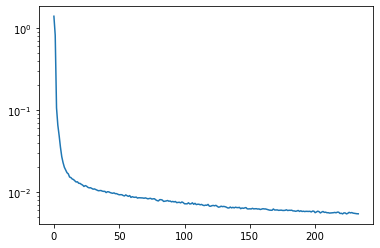

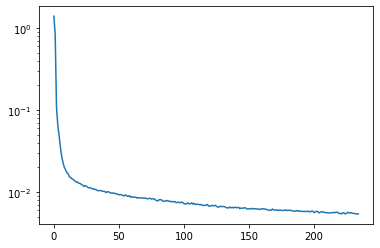

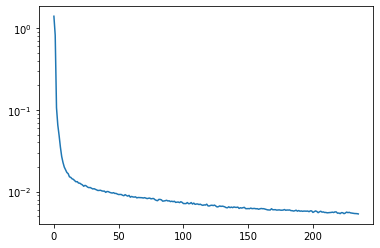

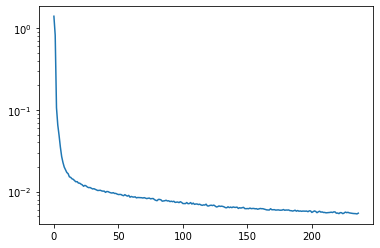

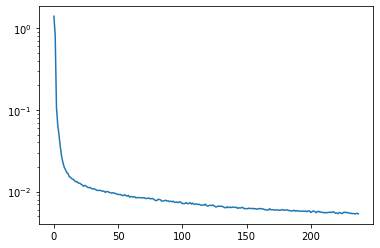

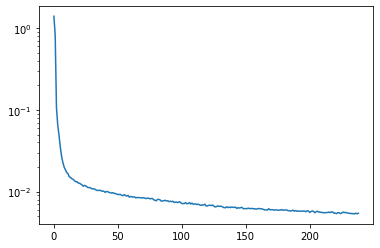

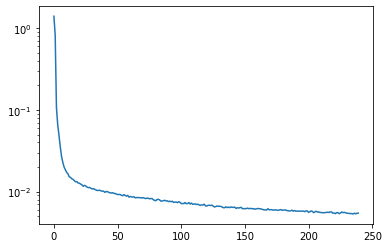

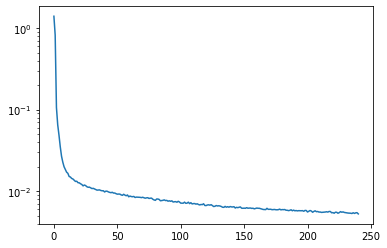

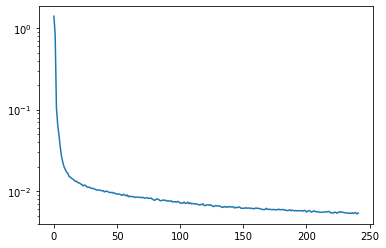

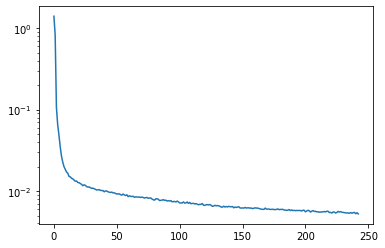

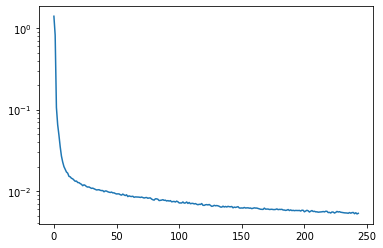

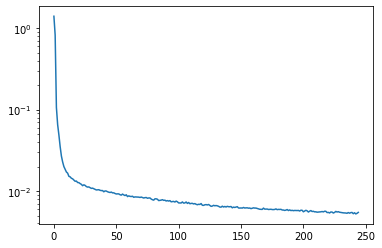

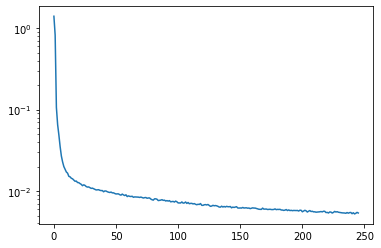

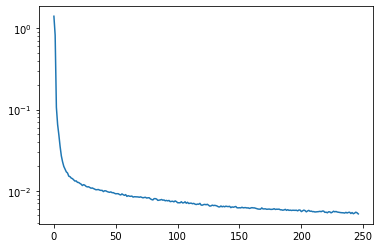

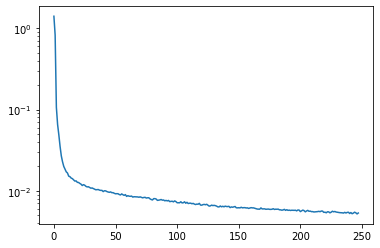

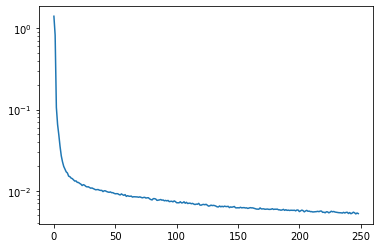

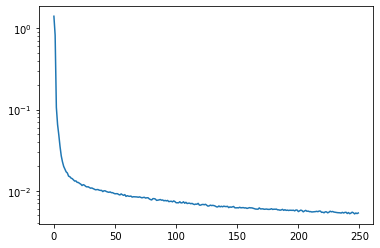

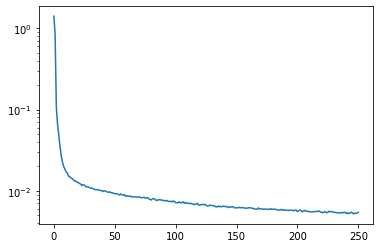

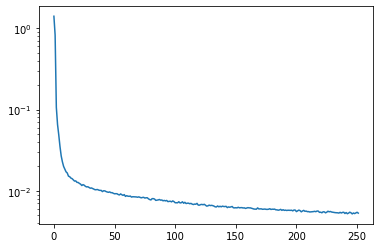

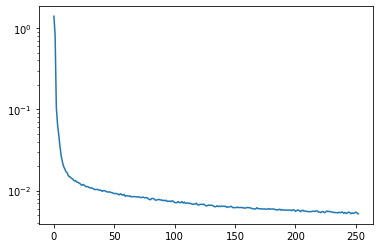

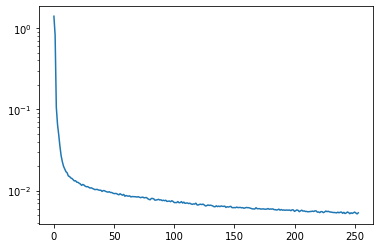

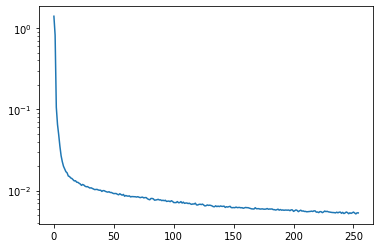

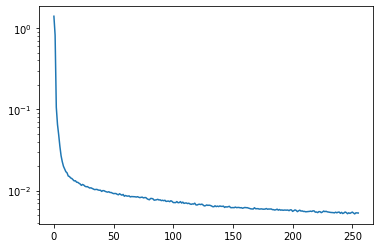

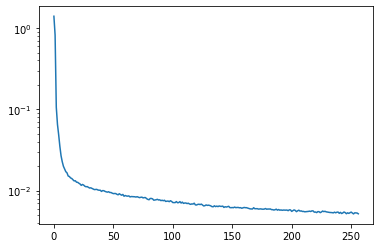

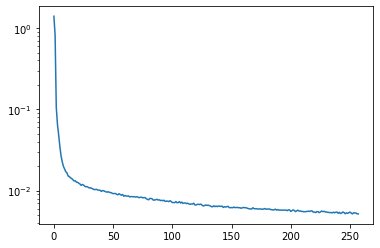

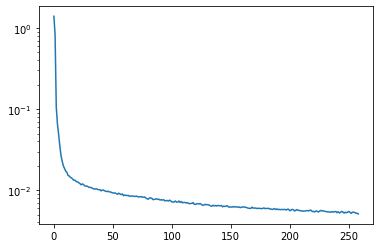

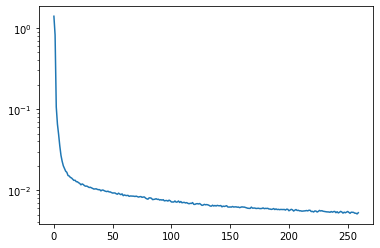

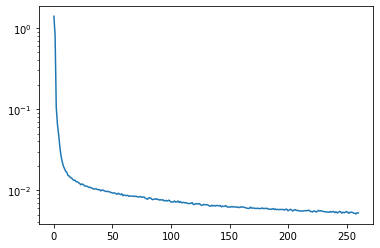

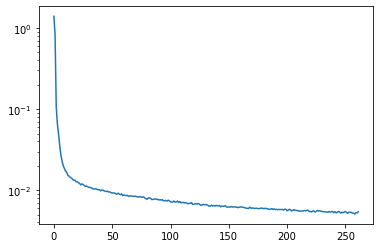

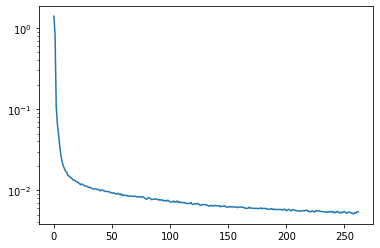

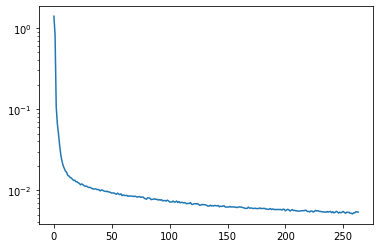

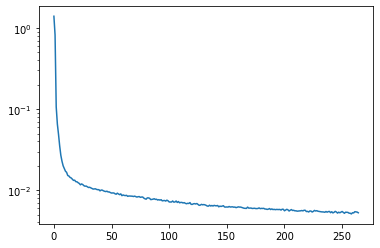

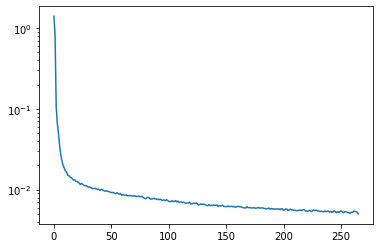

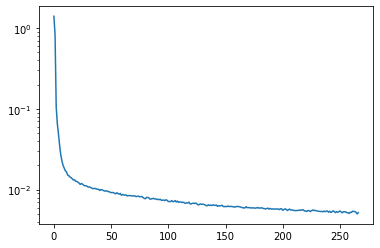

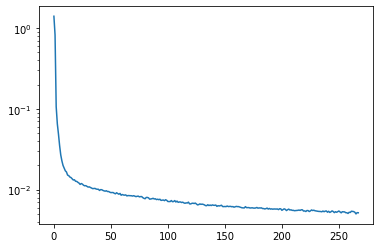

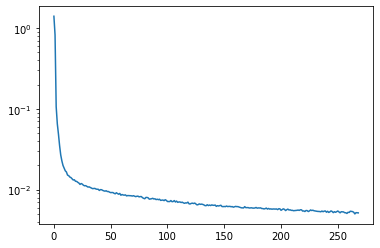

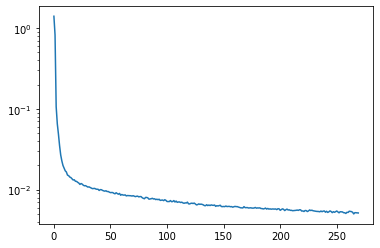

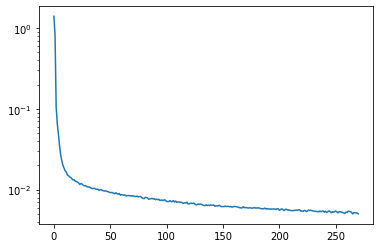

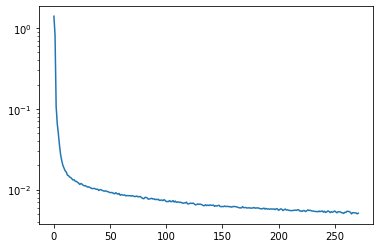

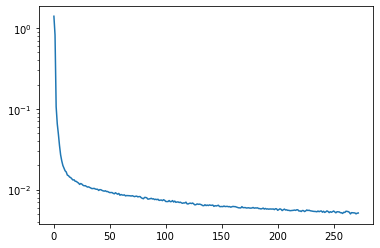

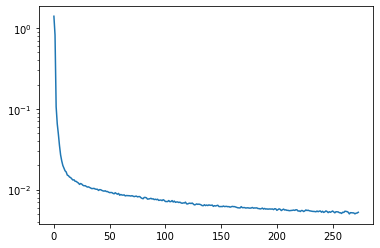

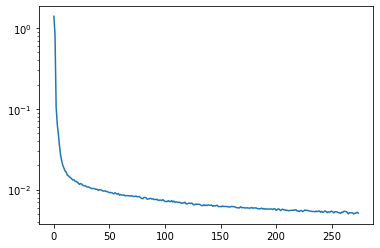

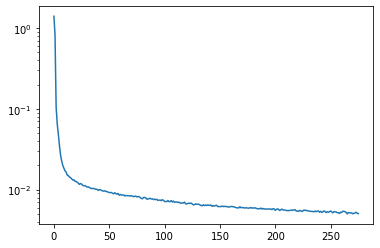

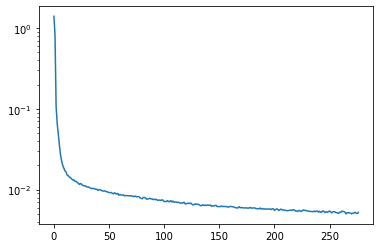

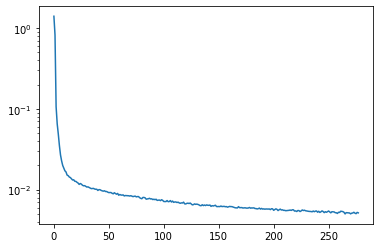

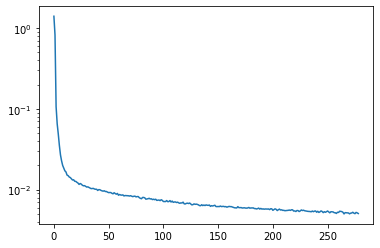

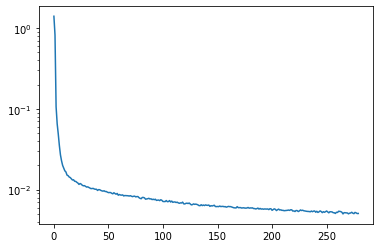

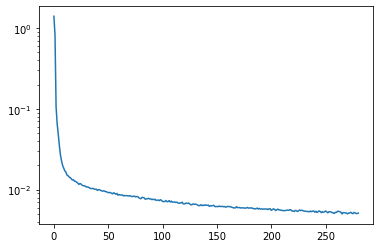

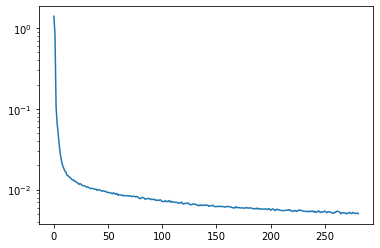

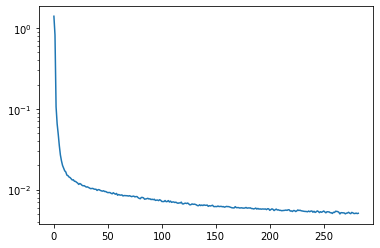

Batch:   0%|          | 0/28271 [00:00<?, ?it/s]

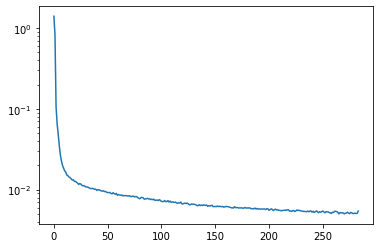

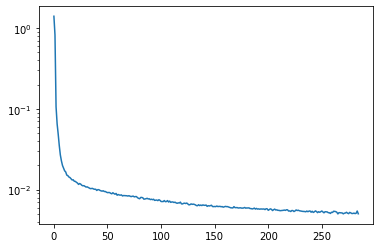

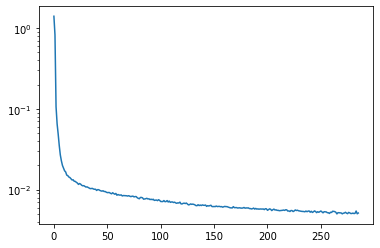

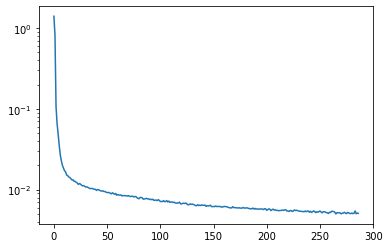

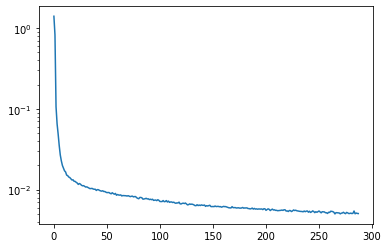

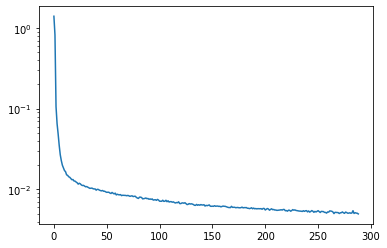

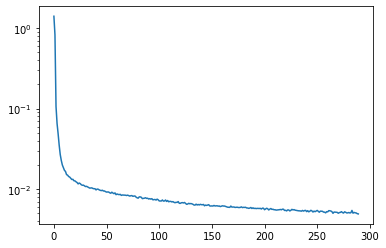

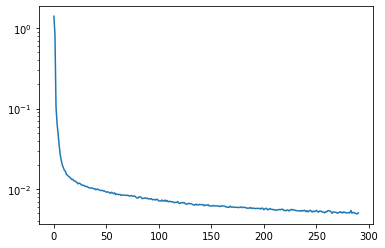

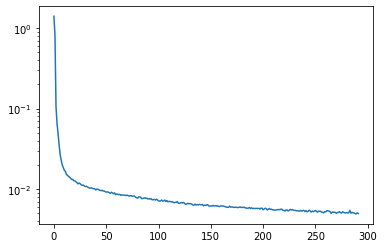

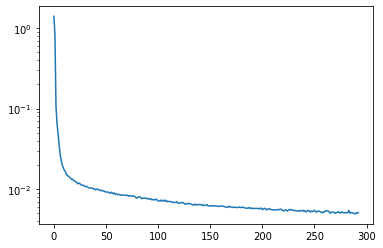

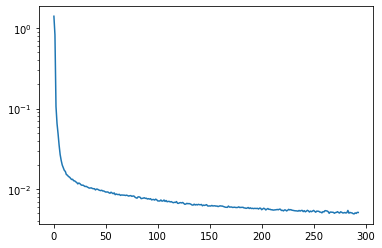

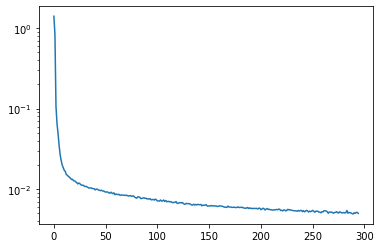

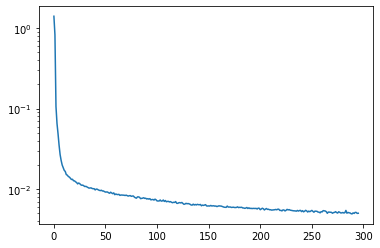

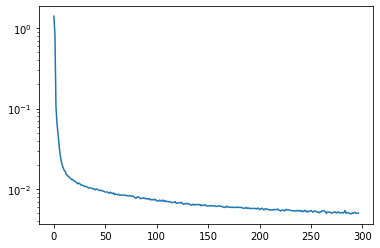

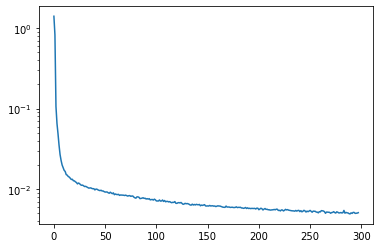

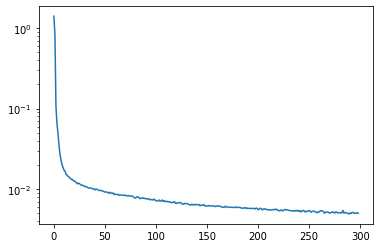

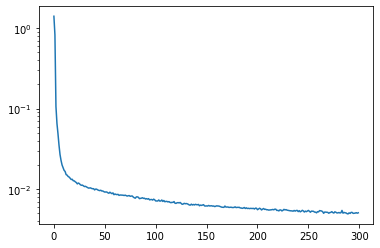

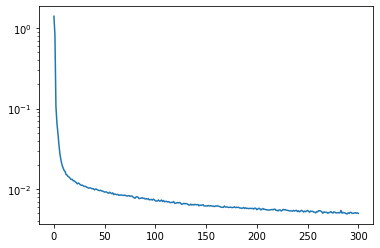

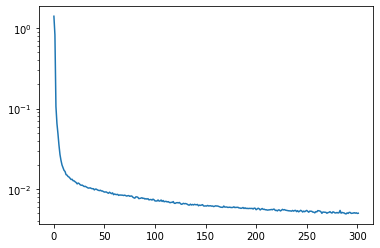

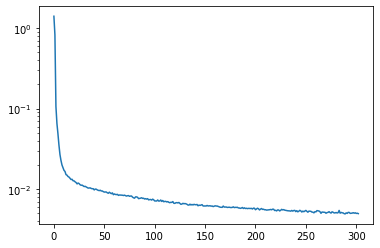

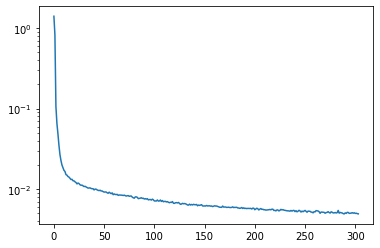

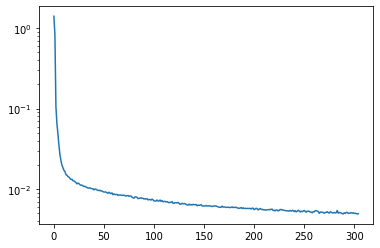

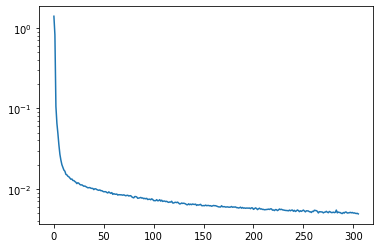

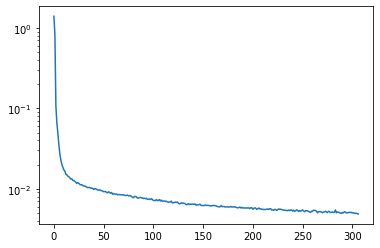

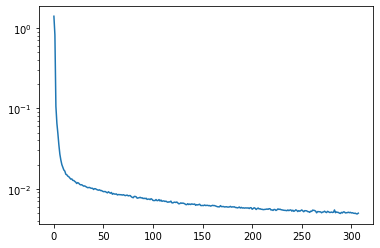

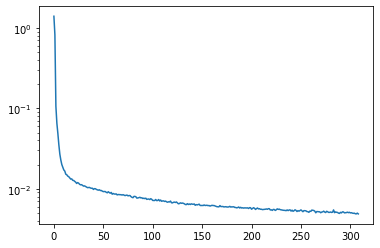

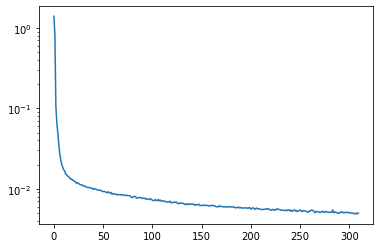

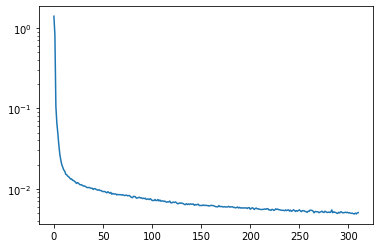

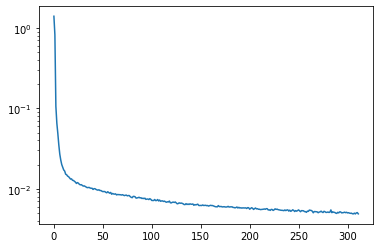

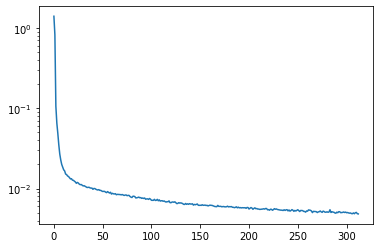

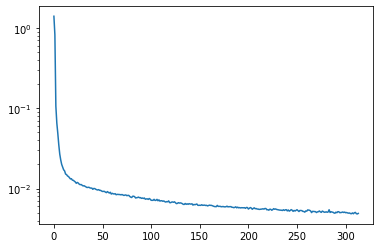

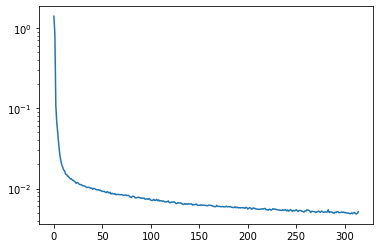

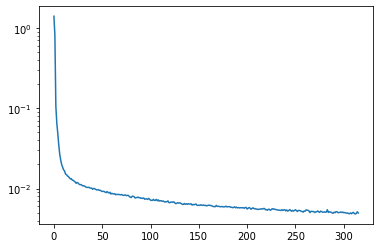

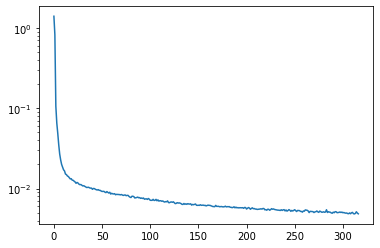

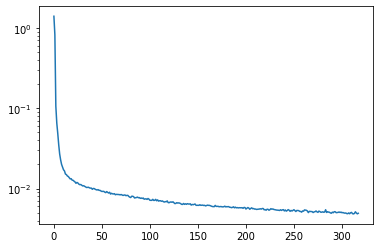

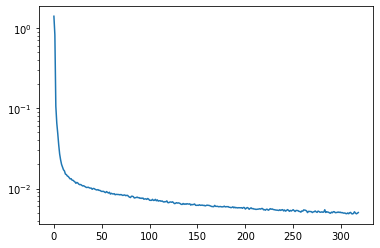

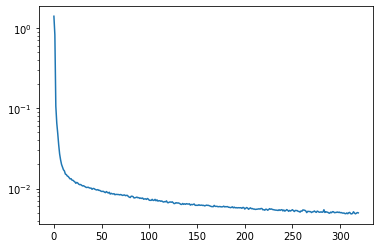

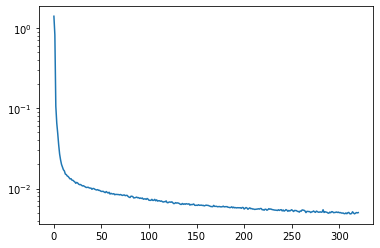

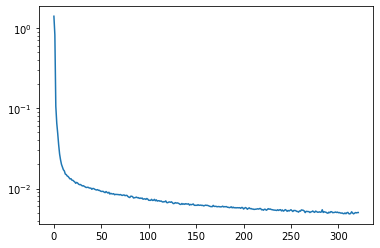

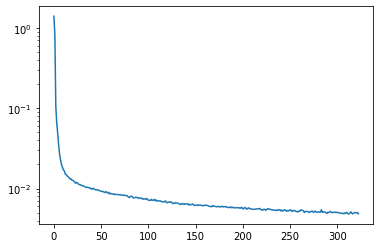

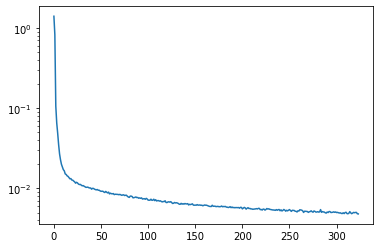

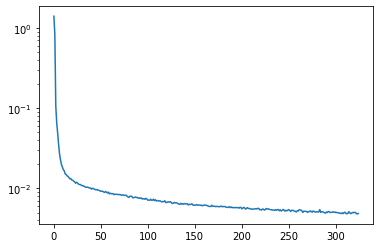

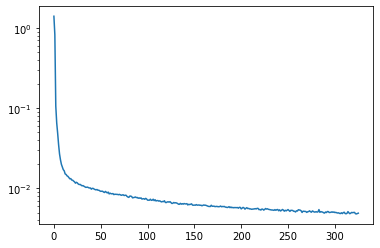

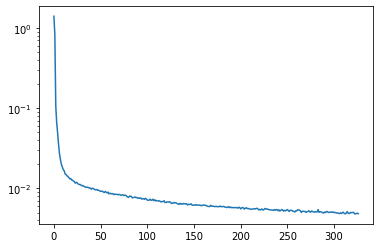

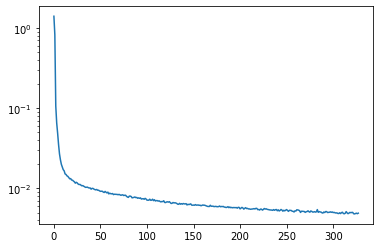

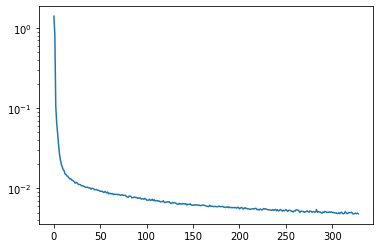

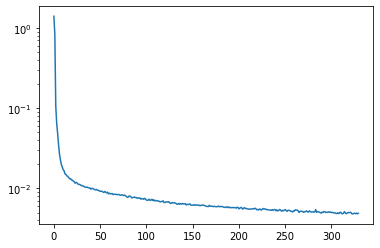

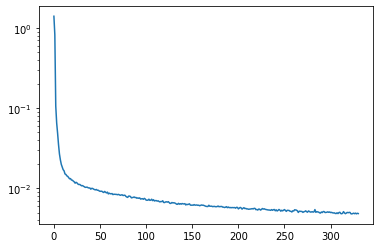

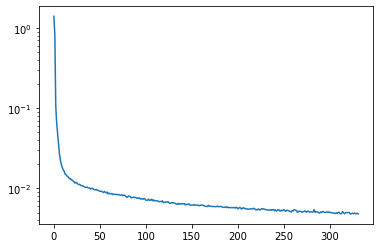

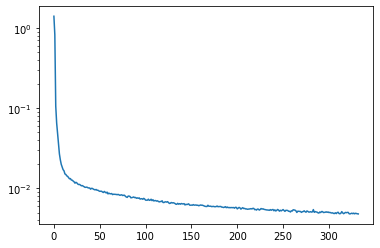

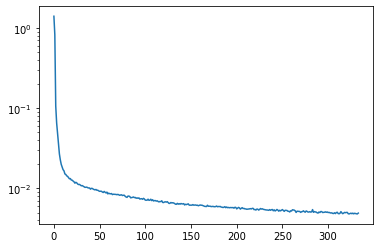

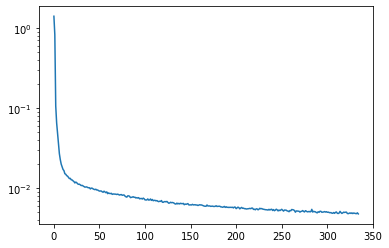

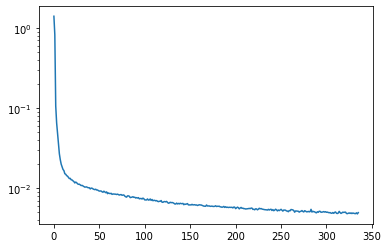

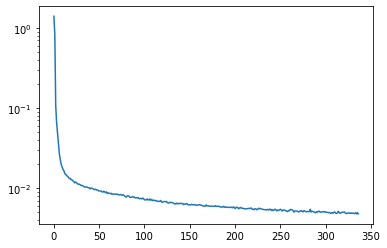

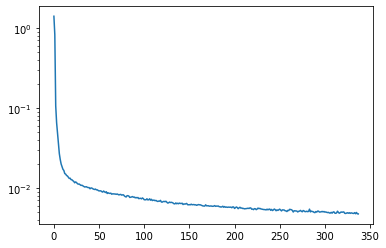

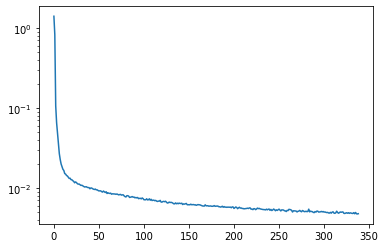

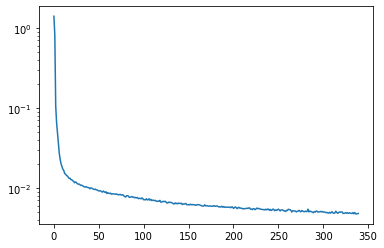

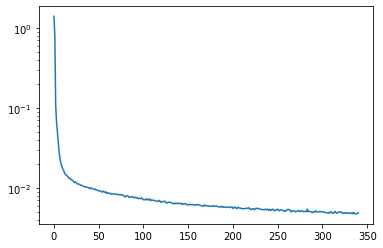

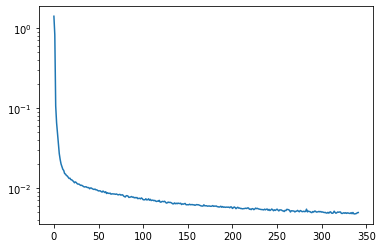

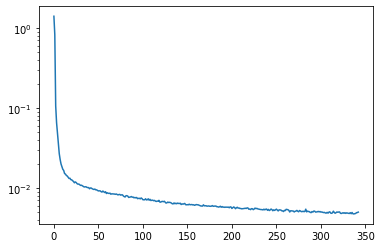

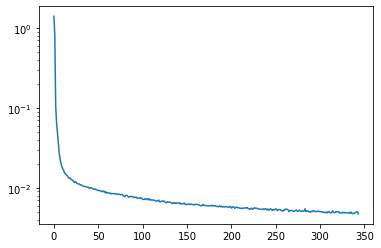

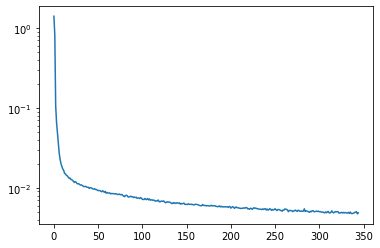

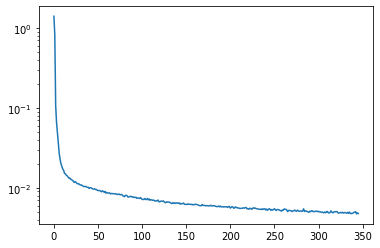

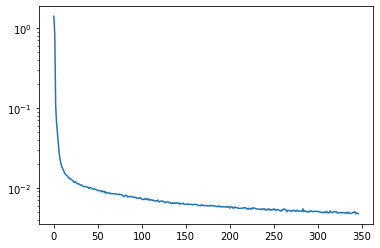

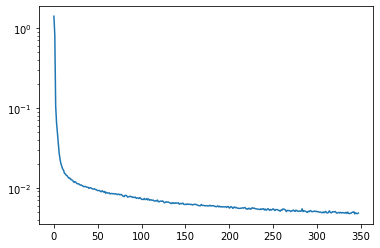

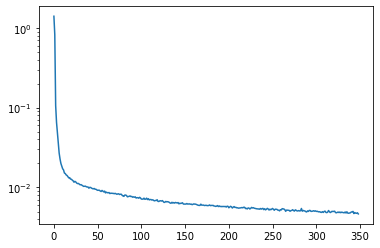

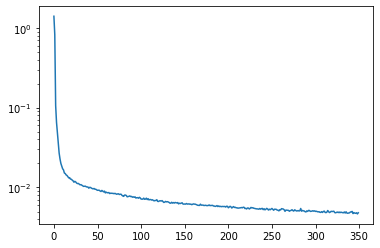

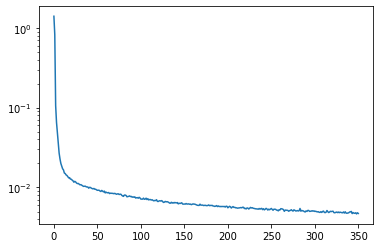

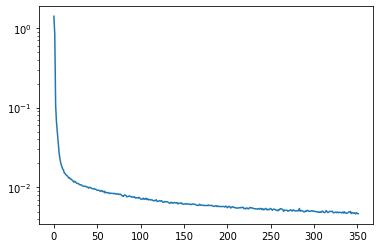

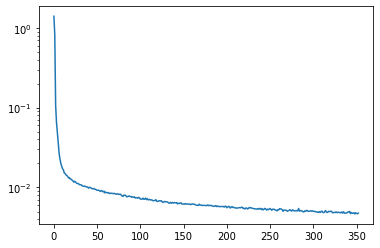

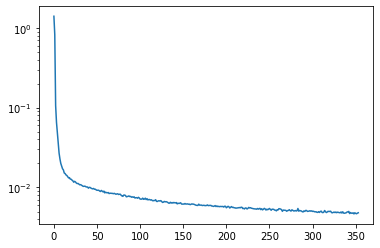

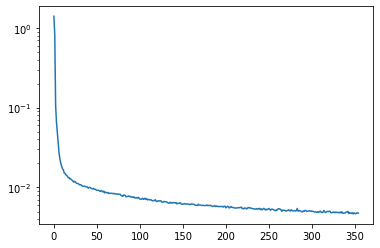

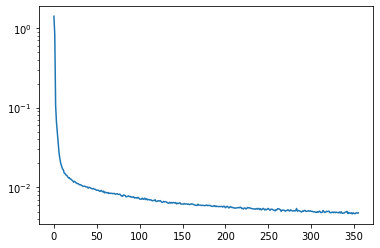

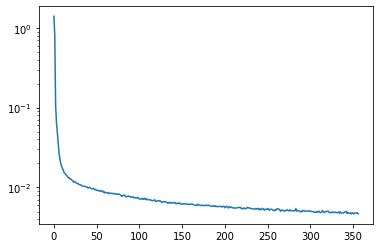

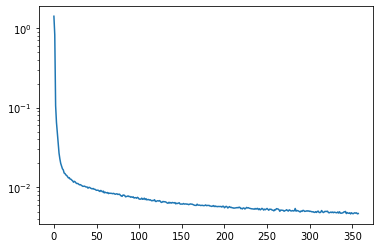

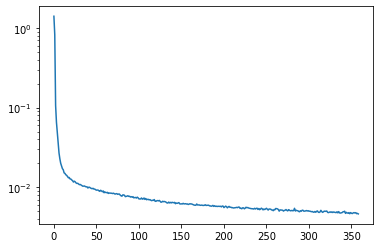

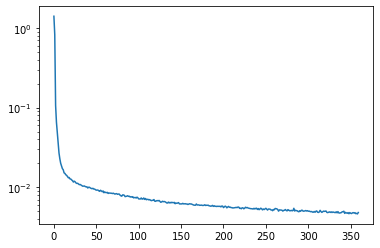

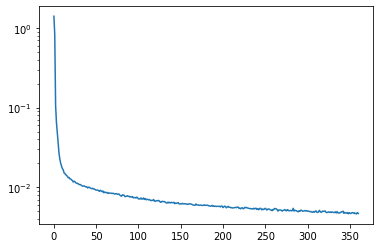

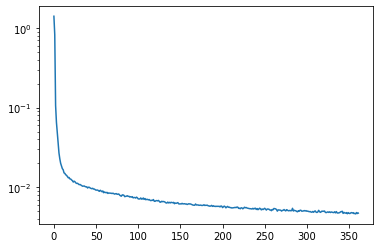

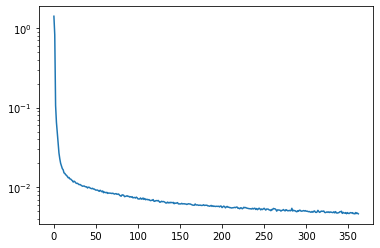

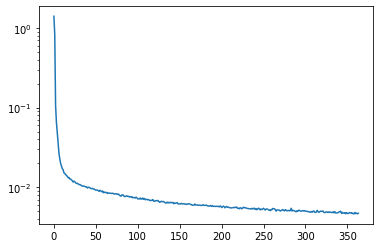

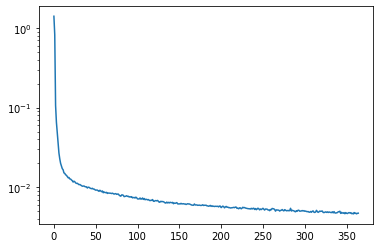

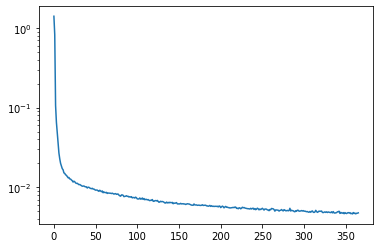

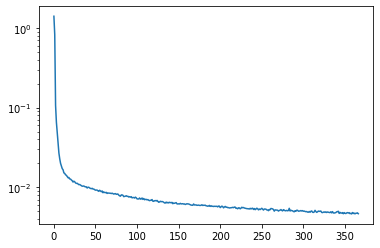

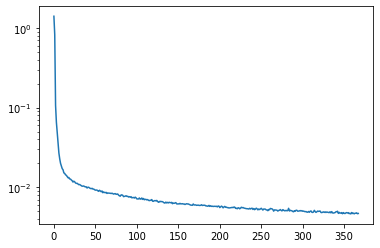

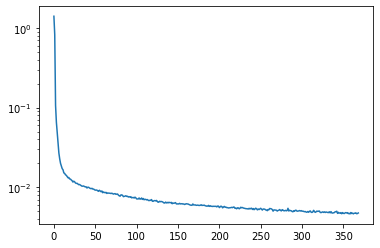

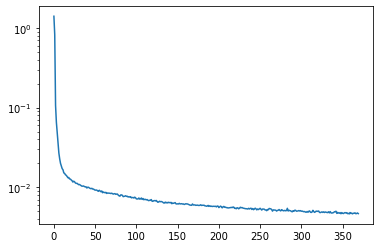

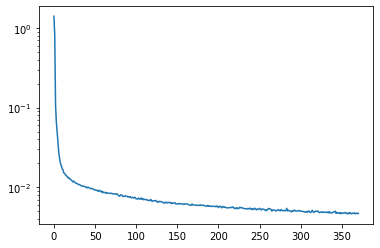

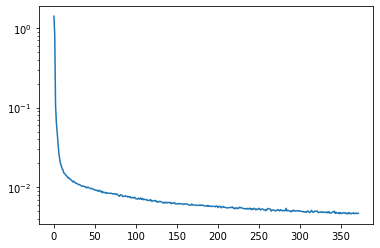

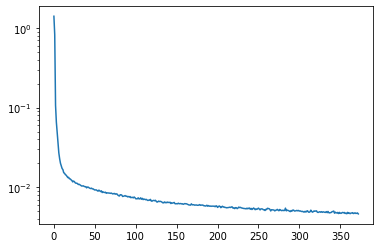

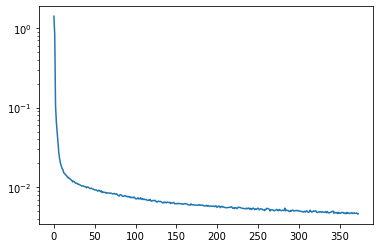

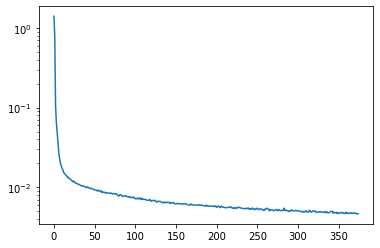

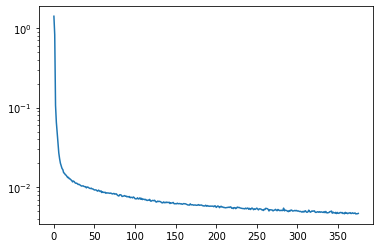

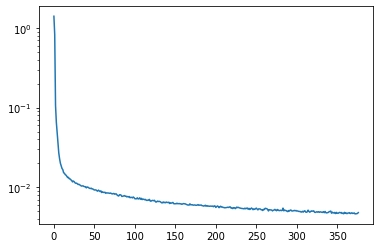

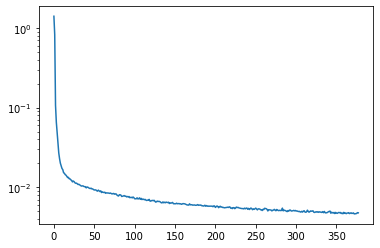

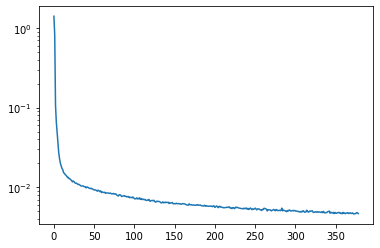

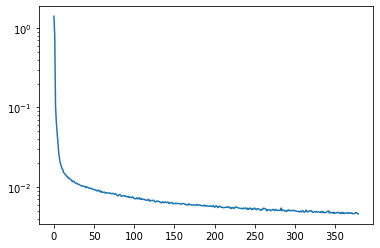

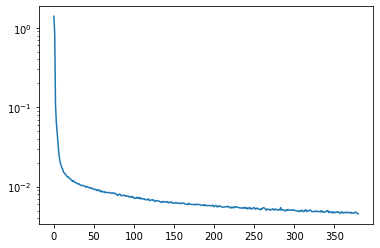

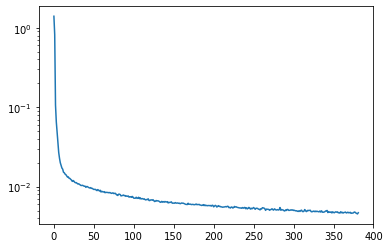

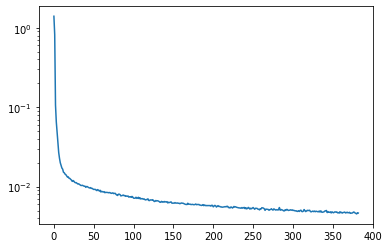

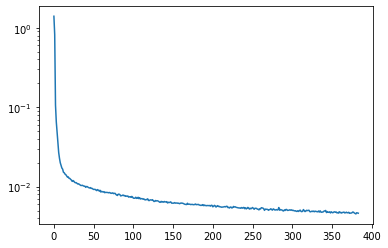

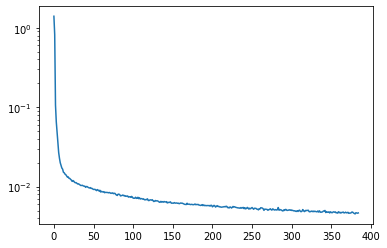

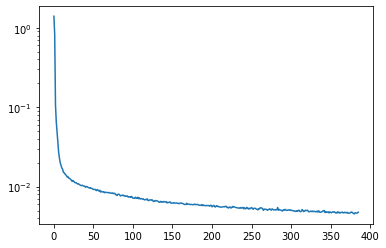

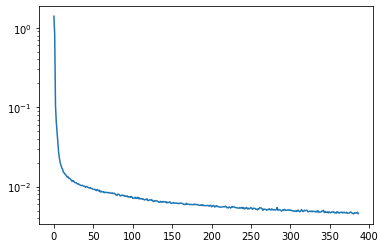

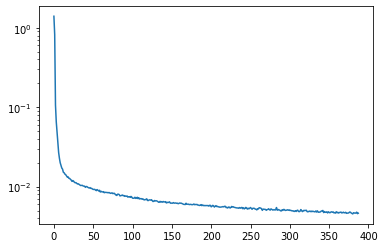

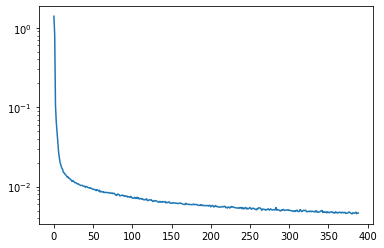

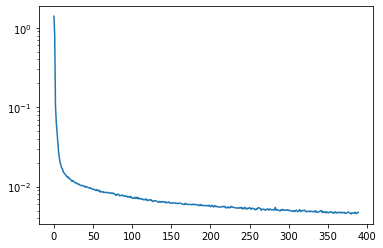

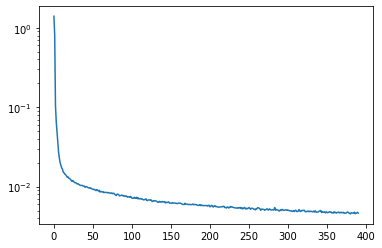

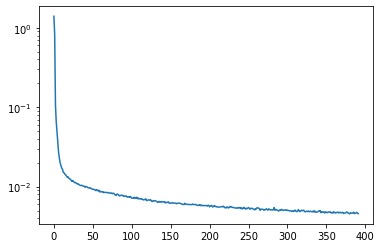

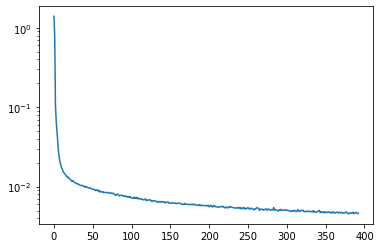

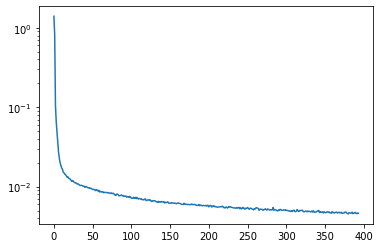

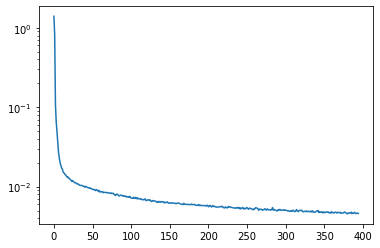

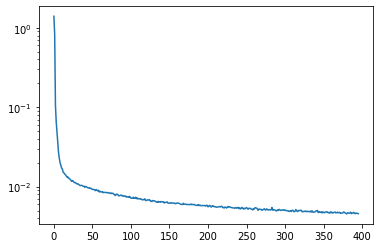

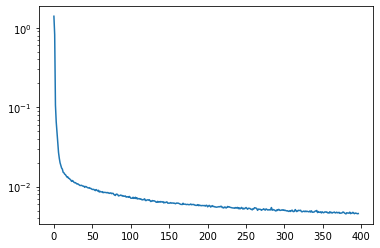

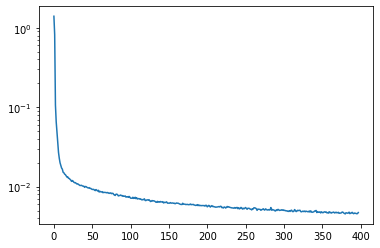

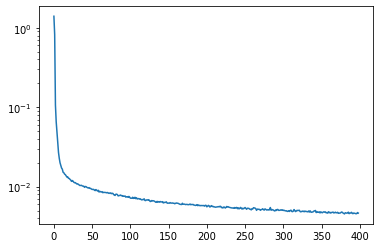

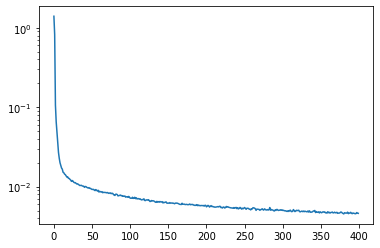

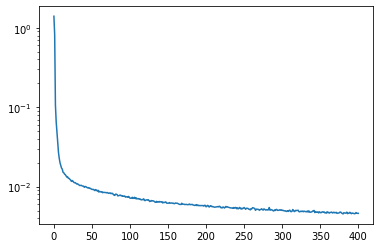

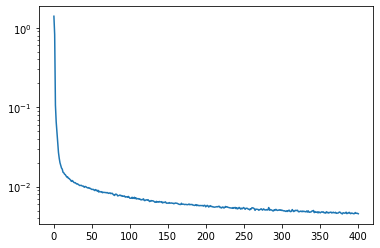

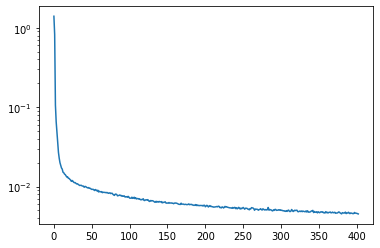

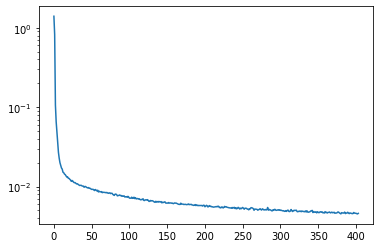

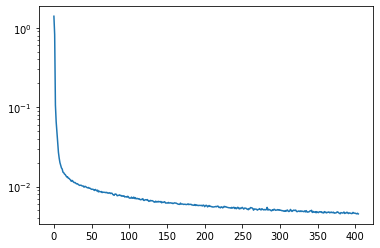

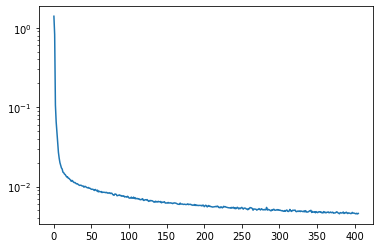

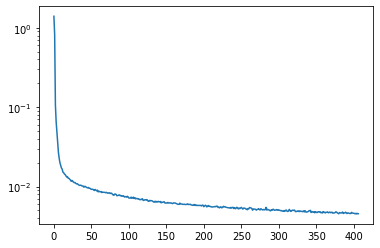

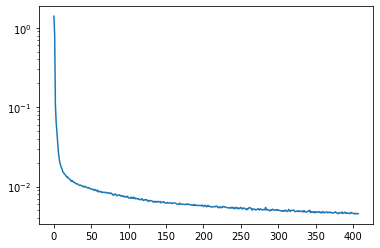

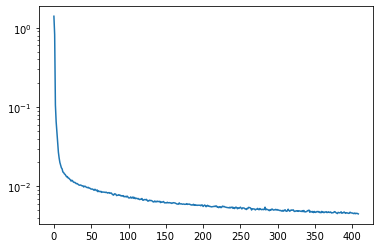

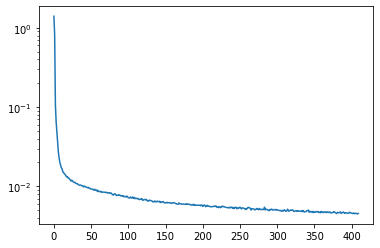

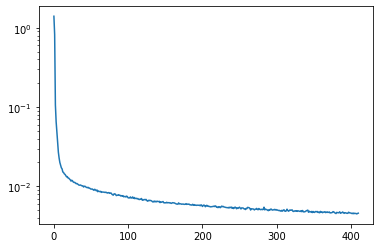

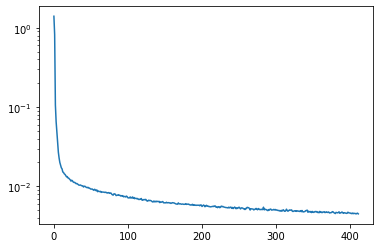

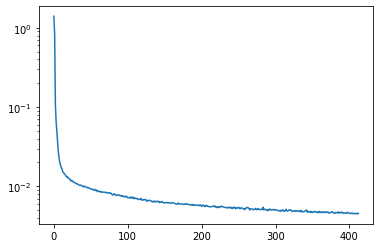

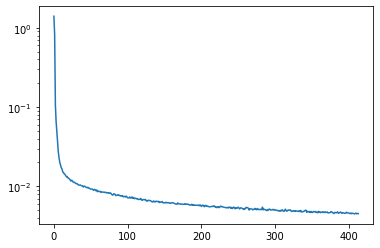

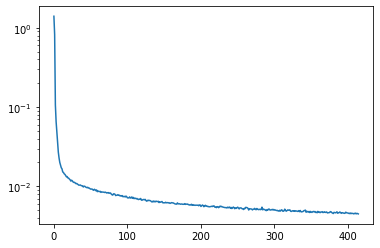

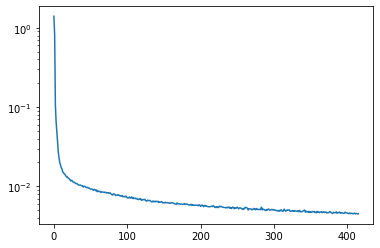

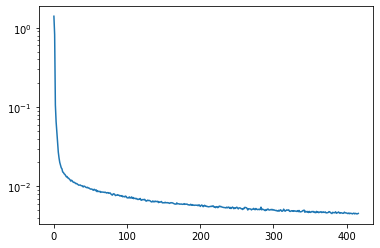

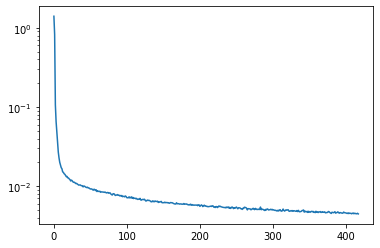

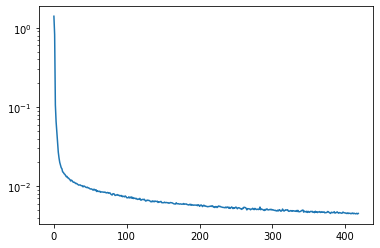

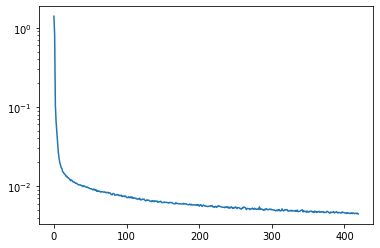

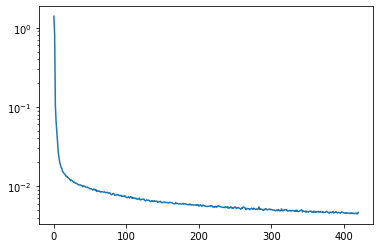

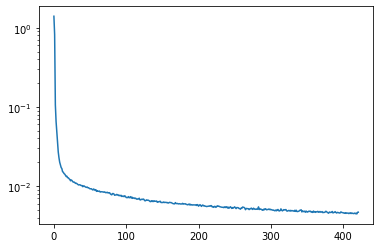

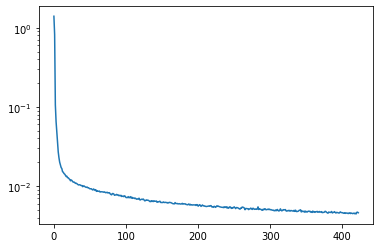

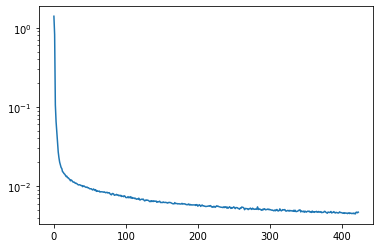

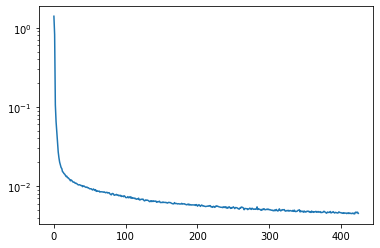

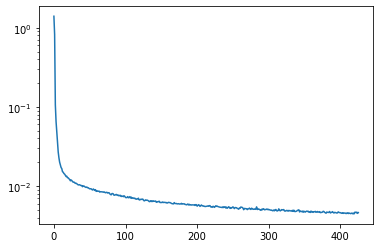

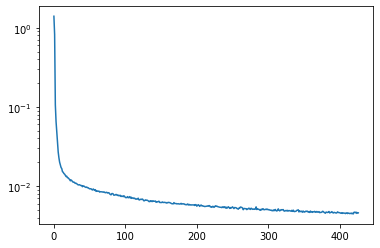

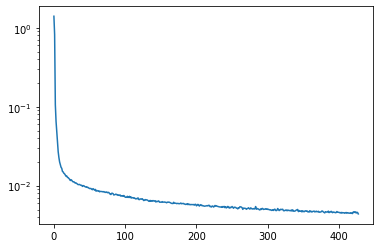

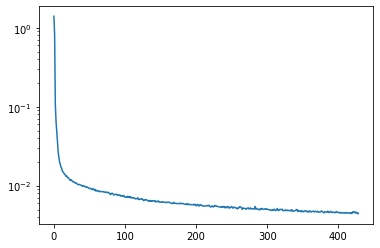

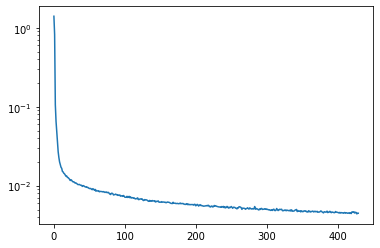

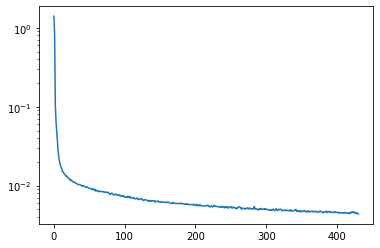

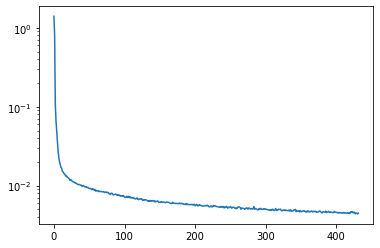

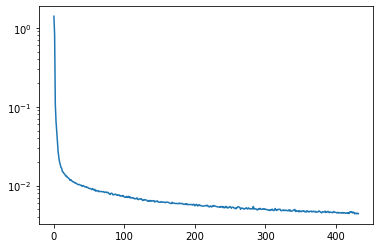

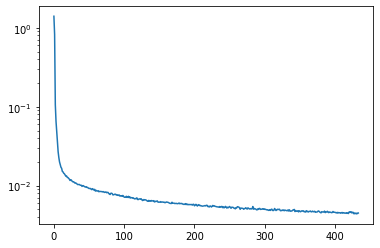

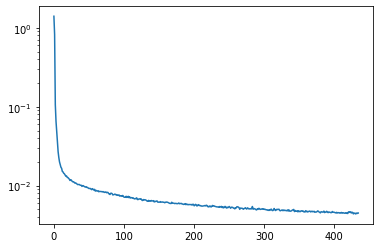

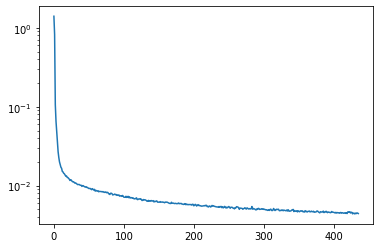

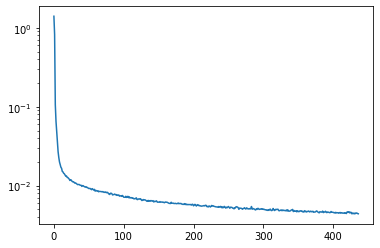

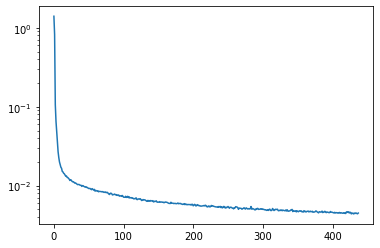

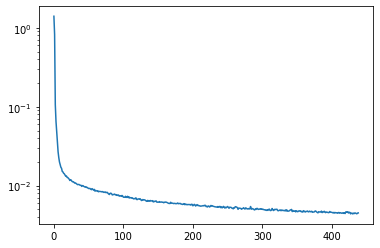

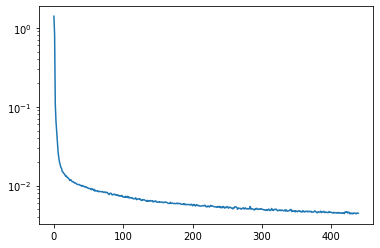

KeyboardInterrupt: 

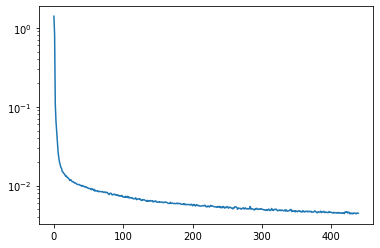

In [6]:
#@markdown ### **Training**
#@markdown
#@markdown Takes about an hour. If you don't want to wait, skip to the next cell
#@markdown to load pre-trained weights

num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)
print('ready to train')
loss_log = []
fig, ax = plt.subplots()
with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1)

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,), device=device
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)
                # print('loss: ', loss)
                
                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
                if tepoch.last_print_n % 100 == 0:
                    # clear_output(wait=False)
                    loss_log.append(np.mean(epoch_loss[-100:]))
                    ax.clear()
                    ax.plot(loss_log)
                    ax.set_yscale('log')  # Set the y-axis to log scale
                    display(fig)
        epoch_loss_mean = np.mean(epoch_loss)
        tglobal.set_postfix(loss=np.mean(epoch_loss))            
        
# Weights of the EMA model
# is used for inference
ema_noise_pred_net = ema.averaged_model

In [14]:
mkdir weights

In [15]:
ls

conda_environment_macos.yaml  eval.py              ray_train_multirun.py
conda_environment_real.yaml   eval_real_robot.py   README.md
conda_environment.yaml        LICENSE              setup.py
data/                         media/               state_dp.ipynb
demo_pusht.py                 multirun_metrics.py  tests/
demo_real_robot.py            __pycache__/         train.py
diffusion_policy/             pyrightconfig.json   weights/
diffusion_policy.egg-info/    ray_exec.py


In [16]:
torch.save(ema.state_dict(), 'weights/one_epoch.pt')

In [49]:
torch.save(noise_pred_net.state_dict(), 'weights/noise_pred_net.pt')

In [27]:
ema_net = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75)


In [20]:
state_dict = torch.load('weights/one_epoch.pt', map_location='cuda')

In [28]:
ema_net.load_state_dict(state_dict)

In [62]:
noise_pred_net.state_dict()['mid_modules.0.blocks.0.block.0.weight'].shape

torch.Size([1024, 1024, 5])

In [66]:
noise_pred_net.parameters

<bound method Module.parameters of ConditionalUnet1D(
  (mid_modules): ModuleList(
    (0): ConditionalResidualBlock1D(
      (blocks): ModuleList(
        (0): Conv1dBlock(
          (block): Sequential(
            (0): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
            (1): GroupNorm(8, 1024, eps=1e-05, affine=True)
            (2): Mish()
          )
        )
        (1): Conv1dBlock(
          (block): Sequential(
            (0): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
            (1): GroupNorm(8, 1024, eps=1e-05, affine=True)
            (2): Mish()
          )
        )
      )
      (cond_encoder): Sequential(
        (0): Mish()
        (1): Linear(in_features=608, out_features=2048, bias=True)
        (2): Unflatten(dim=-1, unflattened_size=(-1, 1))
      )
      (residual_conv): Identity()
    )
    (1): ConditionalResidualBlock1D(
      (blocks): ModuleList(
        (0): Conv1dBlock(
          (block): Sequential(
        

In [56]:
sd = torch.load('weights/noise_pred_net.pt', map_location='cuda')

In [57]:
tmp_net = ConditionalUnet1D(input_dim=4, global_cond_dim=22*16)
tmp_net.load_state_dict(sd)

number of parameters: 7.025972e+07


<All keys matched successfully>

In [60]:
len(sd.keys())

148

In [42]:
ema.state_dict()

{'decay': 0.9999,
 'min_decay': 0.0,
 'optimization_step': 43901,
 'update_after_step': 0,
 'use_ema_warmup': False,
 'inv_gamma': 1.0,
 'power': 0.75,
 'shadow_params': [tensor([[[-0.0379, -0.0021, -0.0152, -0.0057, -0.0109],
           [-0.0189,  0.0044, -0.0025, -0.0006, -0.0382],
           [-0.0050, -0.0005, -0.0136,  0.0062, -0.0048],
           ...,
           [ 0.0138,  0.0048, -0.0076, -0.0100, -0.0090],
           [ 0.0260,  0.0086,  0.0076,  0.0208,  0.0142],
           [ 0.0214,  0.0078,  0.0044,  0.0230, -0.0044]],
  
          [[-0.0671, -0.0423, -0.0303,  0.0017,  0.0096],
           [-0.0057,  0.0044,  0.0193, -0.0022,  0.0014],
           [-0.0151, -0.0102,  0.0030, -0.0132,  0.0118],
           ...,
           [ 0.0061, -0.0107,  0.0043,  0.0013,  0.0179],
           [-0.0215, -0.0130, -0.0063,  0.0127, -0.0007],
           [-0.0179, -0.0209,  0.0095, -0.0089, -0.0147]],
  
          [[ 0.0040,  0.0188,  0.0158, -0.0117, -0.0028],
           [ 0.0089,  0.0235, -0.0104

In [37]:
ema.shadow_params

[tensor([[[-0.0379, -0.0021, -0.0152, -0.0057, -0.0109],
          [-0.0189,  0.0044, -0.0025, -0.0006, -0.0382],
          [-0.0050, -0.0005, -0.0136,  0.0062, -0.0048],
          ...,
          [ 0.0138,  0.0048, -0.0076, -0.0100, -0.0090],
          [ 0.0260,  0.0086,  0.0076,  0.0208,  0.0142],
          [ 0.0214,  0.0078,  0.0044,  0.0230, -0.0044]],
 
         [[-0.0671, -0.0423, -0.0303,  0.0017,  0.0096],
          [-0.0057,  0.0044,  0.0193, -0.0022,  0.0014],
          [-0.0151, -0.0102,  0.0030, -0.0132,  0.0118],
          ...,
          [ 0.0061, -0.0107,  0.0043,  0.0013,  0.0179],
          [-0.0215, -0.0130, -0.0063,  0.0127, -0.0007],
          [-0.0179, -0.0209,  0.0095, -0.0089, -0.0147]],
 
         [[ 0.0040,  0.0188,  0.0158, -0.0117, -0.0028],
          [ 0.0089,  0.0235, -0.0104, -0.0118,  0.0127],
          [ 0.0281,  0.0142,  0.0165,  0.0195,  0.0179],
          ...,
          [ 0.0096, -0.0134, -0.0218, -0.0298, -0.0331],
          [ 0.0021,  0.0188,  0.0158,